In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [2]:
md_2022_0_97 = pd.read_csv('../data/input/milk_data_2022_0-97.csv')
md_2022_97_197 = pd.read_csv('../data/input/milk_data_2022_97-197.csv')

In [25]:
md_2022_0_197 = pd.concat([md_2022_0_97, md_2022_97_197])

In [28]:
md_2022_0_197.to_csv('../data/input/milk_data_2022_0-197.csv')

In [ ]:
md_2022_0_197

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [3]:
class MilkTSDataset(Dataset):
    '''
    Use this Dataset for particular `class_name`, `store`, `item`
    And use ConcatDataset for concatination datasets from several `class_name` and `store`
    
    `params`:
        `class_name`:str: type names which should be choosed (value should be contained in column `class_name` from `data`);
        `store`:int: id of store timeserieses of which we want to create (value should be contained in column `store` from `data`);
        `item`:int: id of product timeserieses of which we want to create (value should be contained in column `item` from `data`);
        `data`:pd.DataFrame: cleaned dataframe;
        `target`:str: target column which contained in `data`;
        `n_prev_days`:int: value of lag;
        `features`:list[str]: which features we should return to output.
    '''
    def __init__(self, class_name:str, store:int, item:int, data:pd.DataFrame,
                 target:str = 'price', n_prev_days:int = 5,
                 features:list[str] = ['cost', 'price', 'sales_units', 'sales_values', 'wasted_units']):
        self.features = features
        self.n_prev_days = n_prev_days
        self.target = target
        
        self.data = data[(data['class_name'] == class_name) & (data['store'] == store) & (data['item'] == item)]
        self.total_count = max(0, len(self.data) - n_prev_days)
    
    def __len__(self):
        return self.total_count
    
    def __getitem__(self, idx):
        output = {'target_price':self.data.iloc[idx + self.n_prev_days][self.target]}
        output = dict(self.data[self.features].iloc[idx:idx + self.n_prev_days].to_dict('list'), **output)
        return output

In [4]:
class MilkTSDatasetClean(Dataset):
    def __init__(self, store:int, item:int, data:pd.DataFrame,
                 target:str = 'price', n_prev_days:int = 5,
                 features:list[str] = ['cost', 'price', 'sales_units', 'sales_values', 'wasted_units']):
        '''
        Use this Dataset for particular `class_name`, `store`, `item`
        And use ConcatDataset for concatination datasets from several `class_name` and `store`
        `params`:
        `class_name`:str: type names which should be choosed (value should be contained in column `class_name` from `data`);
        `store`:int: id of store timeserieses of which we want to create (value should be contained in column `store` from `data`);
        `item`:int: id of product timeserieses of which we want to create (value should be contained in column `item` from `data`);
        `data`:pd.DataFrame: cleaned dataframe;
        `target`:str: target column which contained in `data`;
        `n_prev_days`:int: value of lag;
        `features`:list[str]: which features we should return to output.
        '''
        self.features = features
        self.n_prev_days = n_prev_days
        self.target = target
        self.data = data[(data['store'] == store) & (data['item'] == item)]
        self.total_count = max(0, len(self.data) - n_prev_days)
    
    def __len__(self):
        return self.total_count
    
    def __getitem__(self, idx):
        output = {'target_sales_units':self.data.iloc[idx + self.n_prev_days][self.target]}
        output = dict(self.data[self.features].iloc[idx:idx + self.n_prev_days].to_dict('list'), **output)
        return output

In [42]:
train_ds = torch.load('../data/input/train_dataset.pt')

In [43]:
first_ds = train_ds.datasets[0]

In [44]:
from neuralprophet import NeuralProphet

In [54]:
train_df = train_ds.datasets[0].data.rename(columns={'date': 'ds',
                                                     'sales_units': 'y'})

In [55]:
test_ds = torch.load('../data/input/test_dataset.pt')
test_df = test_ds.datasets[0].data.rename(columns={'date': 'ds',
                                                   'sales_units': 'y'})

In [68]:
features = list(set(train_df.columns) - set(['class_name','y','ds', 'store',
                                             'price_zone_&_class_name', 'item']))
all_cols = features + ['ds', 'y']
train_df = train_df[all_cols]
train_df.set_index('ds', drop=True,inplace=True)
train_df=train_df.shift(periods=1)
train_df=train_df.iloc[1:]
train_df.reset_index(inplace=True)


test_df = test_df[all_cols]
test_df.set_index('ds',drop=True,inplace=True)
test_df=test_df.shift(periods=1)
test_df=test_df.iloc[1:]
test_df.reset_index(inplace=True)

In [75]:
test_df

,ds,sales_value,sales_cost_y,cost,price,StoreInventory,sales_cost_x,y
0,2023-02-17,740.870022,373.600006,46.7,56.99,30.0,373.600006,13.0
1,2023-02-18,455.920013,233.500004,46.7,56.99,22.0,233.500004,8.0
2,2023-02-19,740.870026,233.500004,46.7,56.99,39.0,233.500004,13.0
3,2023-02-20,2279.600063,513.700008,46.7,56.99,-1.0,513.700008,40.0
4,2023-02-21,0.000000,0.000000,46.7,56.99,-1.0,0.000000,0.0
5,2023-02-22,113.980003,93.400002,46.7,56.99,27.0,93.400002,2.0
6,2023-02-23,1082.810036,326.900005,46.7,56.99,68.0,326.900005,19.0
7,2023-02-24,863.400021,560.400009,46.7,56.99,50.0,560.400009,18.0
8,2023-02-25,2279.600037,793.900013,46.7,56.99,40.0,793.900013,40.0
9,2023-02-26,968.830029,373.600006,46.7,56.99,24.0,373.600006,17.0


In [70]:
nprophet_model = NeuralProphet()
for feat in features:
    nprophet_model.add_future_regressor(feat)
metrics = nprophet_model.fit(train_df,
                             freq="D")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (NP.df_utils.check_single_dataframe) - Encountered future regressor with only unique values in training set. Variable will be removed for global modeling if this is true for all time series.
WARNING - (NP.df_utils.check_single_dataframe) - Encountered future regressor with only unique values in training set. Variable will be removed for global modeling if this is true for all time series.
WARNING - (NP.df_utils.check_dataframe) - Encountered future regressor with only unique values in training set across all IDs.Automatically removed variable.
WARNING - (NP.df_utils.check_dataframe) - Encountered future regressor with only unique values in training set across all IDs.Automatically removed variable.
WARNING - (NP.data.processing._check_dataframe) - Removing regressor cost because it is not present in the data.
WARNING - (NP.data.processing._check_dataframe)

Finding best initial lr:   0%|          | 0/203 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [71]:
future_df = nprophet_model.make_future_dataframe(test_df[features+['ds','y']],
                                                 regressors_df=test_df[features],
                                                 periods = 7,
                                                 n_historic_predictions=len(test_df),)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 95.652% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


preds_df_2 = nprophet_model.m(train_df[['ds', 'y']])

In [72]:
preds_df_2 = nprophet_model.predict(future_df[['ds', 'y', 'StoreInventory', 'sales_value', 'sales_cost_y', 'sales_cost_x']])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 3it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [77]:
((preds_df_2['y']-preds_df_2['future_regressor_sales_value'])**2).mean()

1.1974053025287132

In [74]:
nprophet_model.plot(preds_df_2)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '4c8b73fe-6c30-4d1a-9b4b-1218666e56a5',
              'x': array([datetime.datetime(2023, 2, 17, 0, 0),
                          datetime.datetime(2023, 2, 18, 0, 0),
                          datetime.datetime(2023, 2, 19, 0, 0),
                          datetime.datetime(2023, 2, 20, 0, 0),
                          datetime.datetime(2023, 2, 21, 0, 0),
                          datetime.datetime(2023, 2, 22, 0, 0),
                          datetime.datetime(2023, 2, 23, 0, 0),
                          datetime.datetime(2023, 2, 24, 0, 0),
                          datetime.datetime(2023, 2, 25, 0, 0),
                          datetime.datetime(2023, 2, 26, 0, 0),
                          datetime.datetime(2023, 2, 27, 0, 0),
              

# Clean


In [2]:
import torch
from torch import nn
from tqdm import tqdm

from datetime import datetime

In [3]:
path='../data/input/data_years_fillna.csv'
data = pd.read_csv(path)

In [4]:
item = 27199
store = 8
subsample = data[(data.item == item) & (data.store == store)]

In [5]:
data_by_date = subsample.groupby('date').mean().reset_index()
data_by_date.date = pd.to_datetime(data_by_date.date)

In [6]:
data_by_date.isna().sum()

date           0
item           0
store          0
sales_units    0
sales_value    0
price          0
cost           0
dtype: int64

In [7]:
date_split = datetime(2023, 3, 1)

In [8]:
train_data = data_by_date[data_by_date.date<date_split]
test_data = data_by_date[data_by_date.date>=date_split]

In [9]:
test_data.shape

(80, 7)

In [10]:
target:str = 'sales_units'

In [200]:
BATCH_SIZE = 3
device = 'cpu'

In [201]:
def get_subsample(subsample:pd.DataFrame,
                  columns:str = ['sales_units', 'price', 'cost'],
                  target:str = 'sales_units',
                  lag:int = 14):
    data = subsample[columns]
    n = data.shape[0]//lag
    data_norm = (data-data.mean())/data.std()
    data_norm.fillna(0,inplace=True)
    def get_batch():
        i=0
        while i < n:
            j = 0
            batch_features, batch_target = [], []
            if (i+1)*lag + 1 > data.shape[0]:
                features = data_norm.iloc[i*lag:(i+1)*lag].values
                target_values = data.iloc[i*lag+1:(i+1)*lag+1][target].values
                batch_features.append(features)
                batch_target.append(target_values)
                j = BATCH_SIZE
            while j < BATCH_SIZE:
                if (i+1)*lag + 1 < data.shape[0]:
                    features = data_norm.iloc[i*lag:(i+1)*lag].values
                    target_values = data.iloc[i*lag+1:(i+1)*lag+1][target].values
                else:
                    continue
                batch_features.append(features)
                batch_target.append(target_values)
                i+=1
                j+=1
            batch_features = torch.tensor(batch_features)
            batch_target = torch.tensor(batch_target)
            yield batch_features.to(device, dtype=torch.float64), batch_target.to(device, dtype=torch.float64)
    return get_batch

In [202]:
train_loader = get_subsample(train_data)()
test_loader = get_subsample(test_data)()

In [203]:
for i in train_loader:
    print(i[0].shape)

torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])
torch.Size([3, 14, 3])


ValueError: expected sequence of length 14 at dim 1 (got 11)

In [199]:
train_data.shape[0]//30

26

In [195]:
def plot_train_process(train_loss, val_loss, title_suffix=''):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))

    axes.set_title(' '.join(['Loss', title_suffix]))
    axes.plot(train_loss, label='train')
    axes.plot(val_loss, label='validation')
    axes.legend()
    plt.savefig('Loss.png')
    

def train_loop(model, train_dataloader, optimizer, criterion, device = 'cpu', clip=0.5):
    losses = []
    for batch in train_dataloader:
        X_batch, y_batch = batch
        output = model(X_batch)
        # print(X_batch)
        # print(((output-y_batch)**2).mean())
        loss = criterion(output, y_batch)
        # loss = ((output-y_batch)**2).mean()
        optimizer.zero_grad()
        losses.append(loss.item())
        loss.backward()
        
        # grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # print(loss)

        optimizer.step()
    return torch.Tensor(losses).mean()

def val_loop(model, dataloader, criterion, device = 'cpu'):
    losses = []
    for batch in dataloader:
        X_batch, y_batch = batch
        output = model(X_batch)
        loss = criterion(output, y_batch)
        losses.append(loss.detach().cpu())
    return torch.Tensor(losses).mean()

def test_loop(model, dataloader, device = 'cpu'):
    y_pred = []
    y_gt = []
    for batch in dataloader:
        X_batch, y_batch = batch
        output = model(X_batch)
        y_pred.append(output)
        y_gt.append(y_batch)
    return y_pred, y_gt

def train(model, 
          train_dataloader, 
          val_dataloader, 
          optimizer, 
          criterion,
          epochs:int = 100, 
          plot_loss:bool = True, 
          every_epoch:int = 5, 
          device = 'cpu'):
    train_loss_per_epoch = []
    val_loss_per_epoch = []
    for e in tqdm(range(1, epochs+1)):
        loss = train_loop(model, train_dataloader(), optimizer, criterion, device = device)
        # print(f'e{e}')
        if e % every_epoch == 0:

            with torch.no_grad():
                val_loss = val_loop(model, val_dataloader(), criterion, device = device)

            train_loss_per_epoch.append(loss)
            val_loss_per_epoch.append(val_loss)

        if plot_loss and e % every_epoch == 0:
            plot_train_process(train_loss_per_epoch, val_loss_per_epoch)
            
    output = {}
    output['model'] = model
    output['train_loss'] = train_loss_per_epoch
    output['val_loss'] = val_loss_per_epoch
    return output

In [146]:
import torch
from torch import nn

class CatEmbLSTM(nn.Module):
    def __init__(self, num_input_size = 8, lstm_h = 128, lstm_num_layers = 2,
                 batch_first = True, fc_hidden = 128,dropout=0.5):
        super(CatEmbLSTM, self).__init__()
        self.fc_in=nn.Linear(num_input_size,fc_hidden)
        self.rnn = nn.LSTM(fc_hidden, lstm_h, lstm_num_layers, batch_first = batch_first,dropout=dropout)

        self.fc1 = nn.Linear(lstm_h, fc_hidden)
        self.fc_out = nn.Linear(lstm_h, 1)

        self.norm_num_features =  nn.LayerNorm(num_input_size)

        self.func_activ = nn.LeakyReLU()
        # self.drop=nn.Dropout(p=dropout)

        
    def forward(self, x):
        num_feat = x
        # print(num_feat.shape)
        normalized_num_feat = self.norm_num_features(num_feat)
        num_rnn_input =  self.func_activ(self.fc_in(normalized_num_feat))
        output_feat, (hn, cn) = self.rnn(num_rnn_input)
        output = self.fc_out(output_feat)
        return output.reshape(output.shape[:-1])

/home/otvc/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
 20%|██        | 20/100 [00:10<00:44,  1.80it/s]/tmp/ipykernel_15701/3631438494.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 1, figsize=(15, 5))
100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


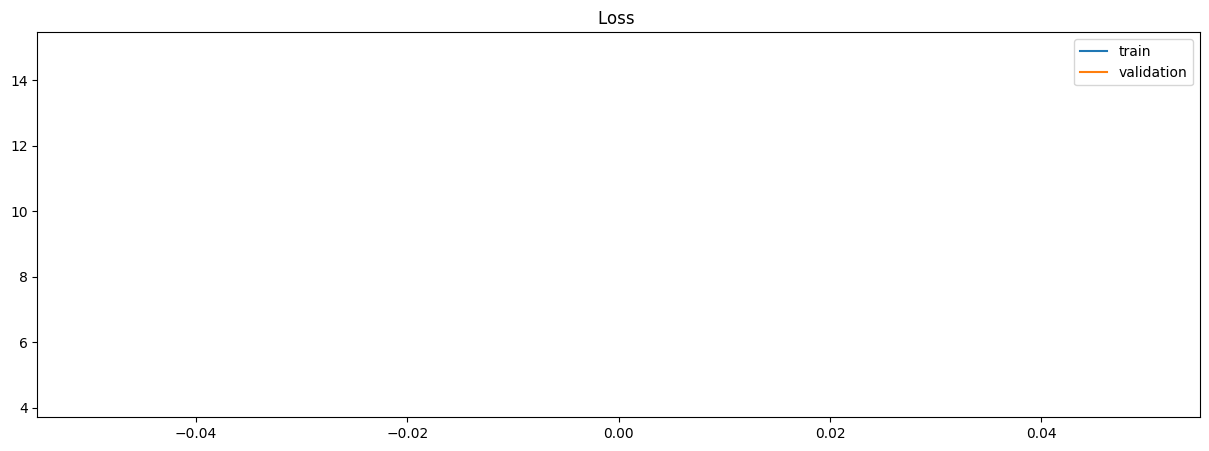

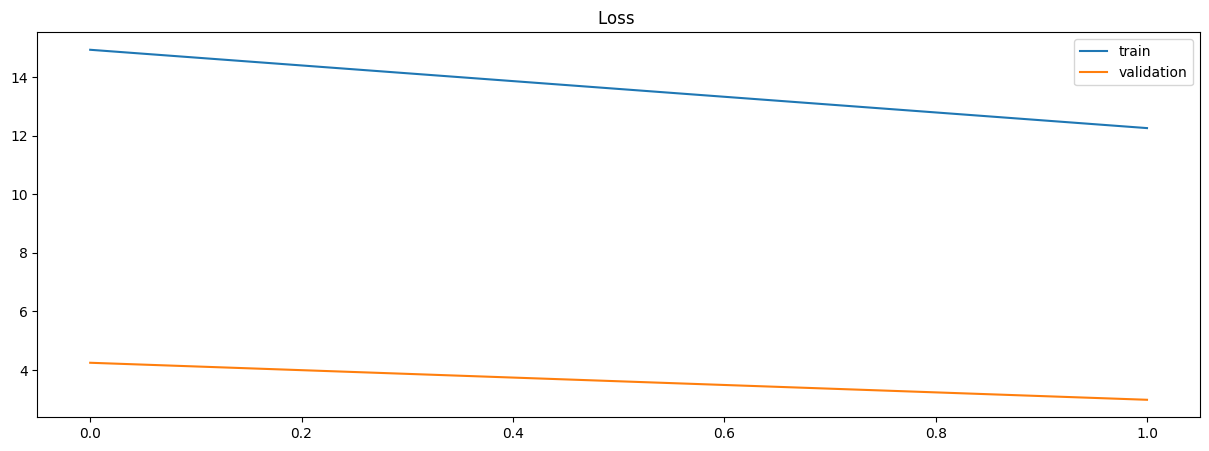

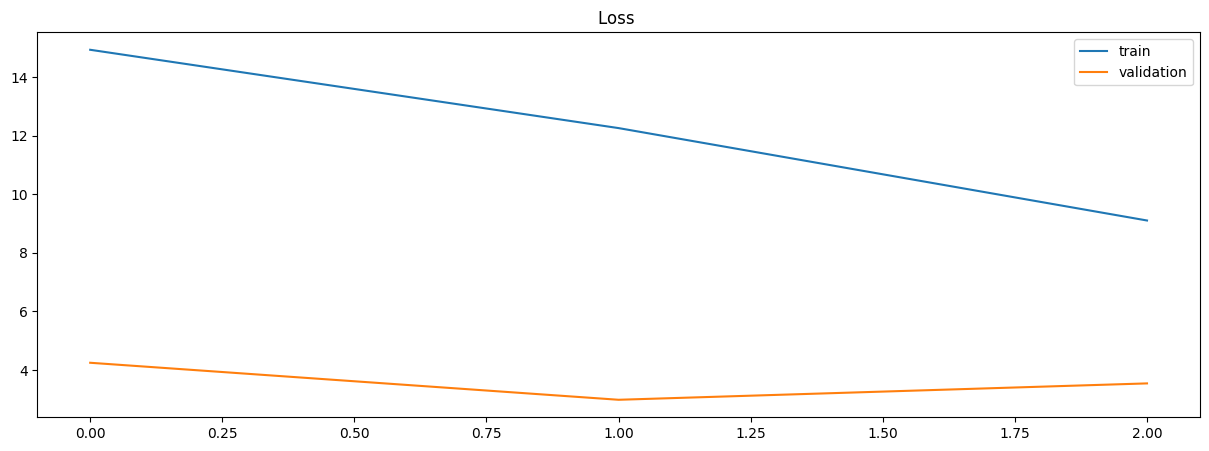

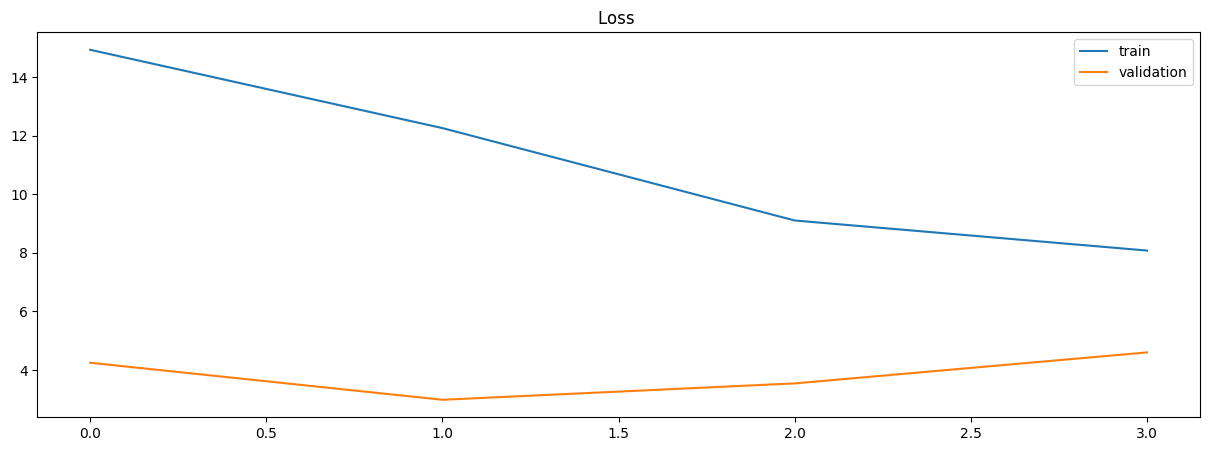

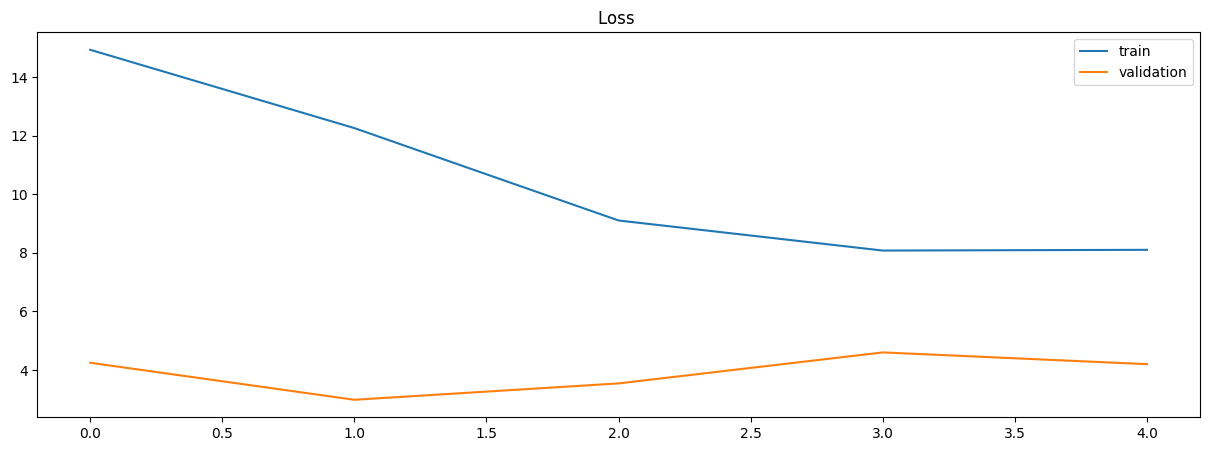

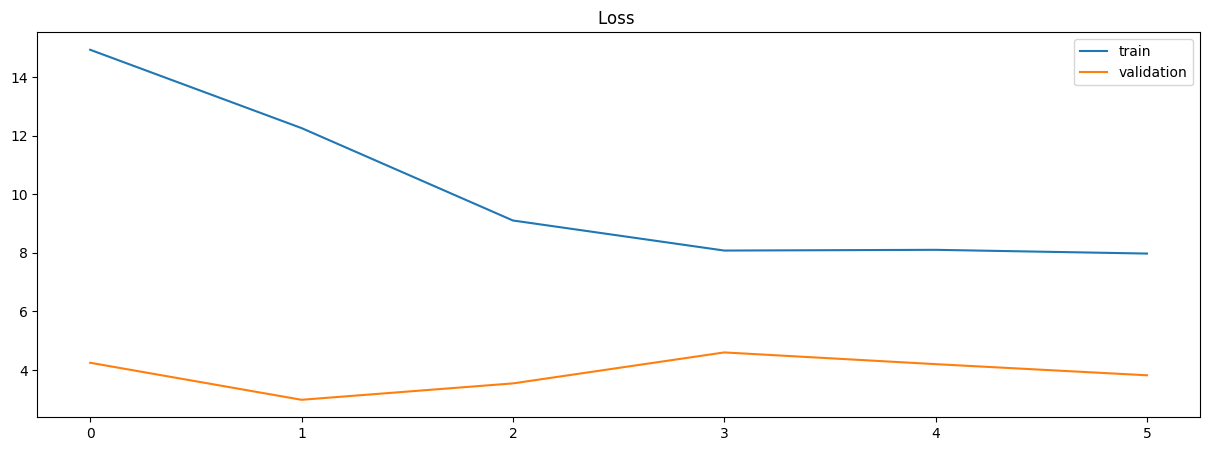

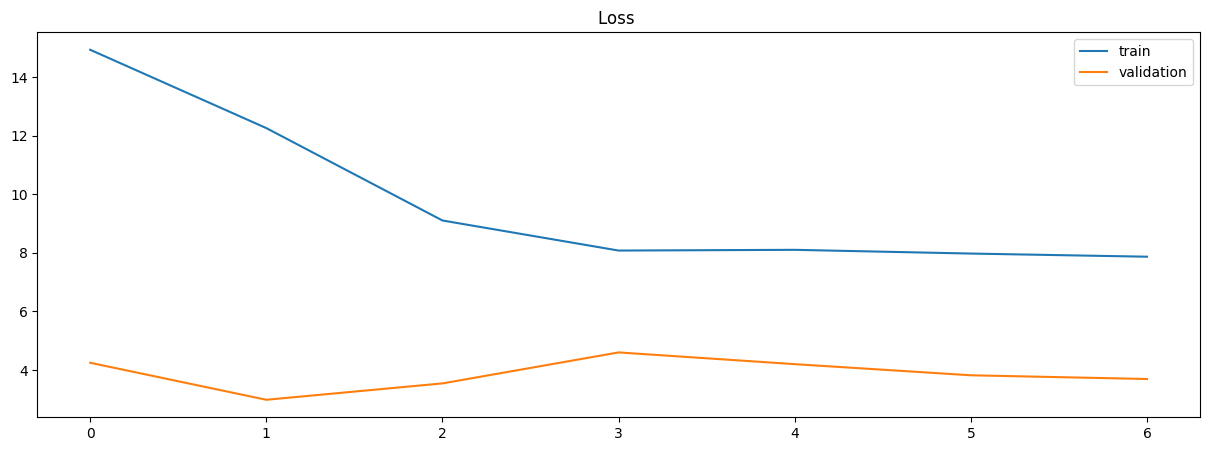

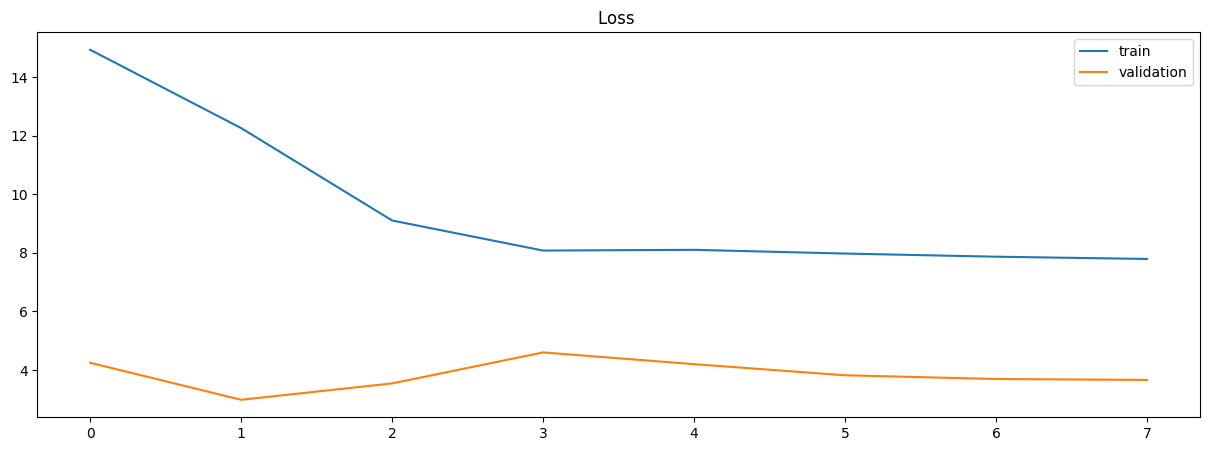

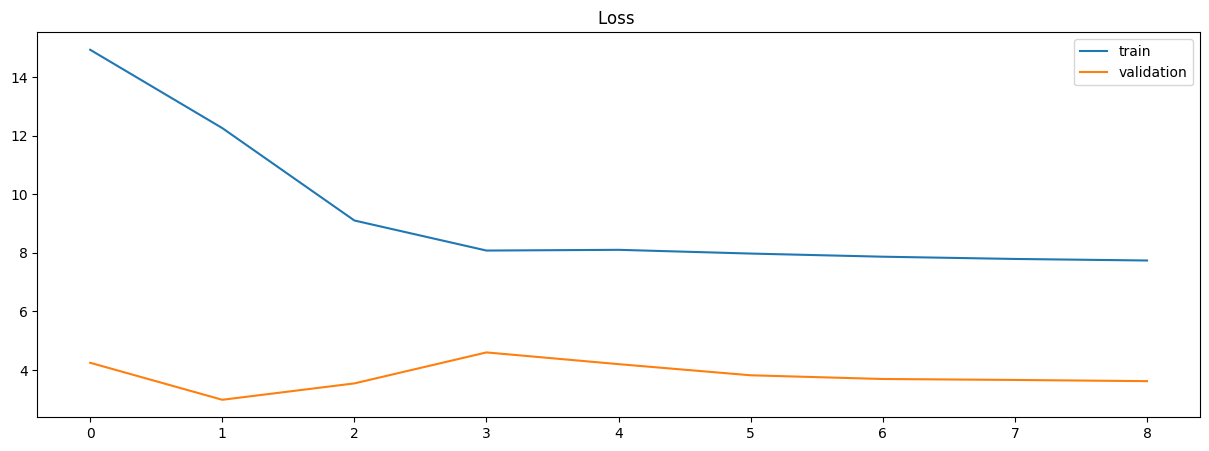

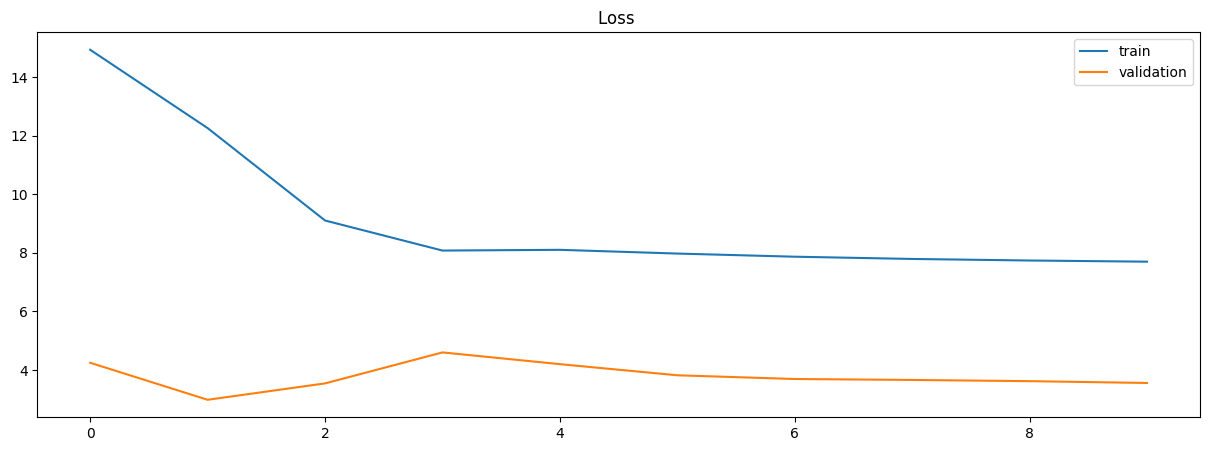

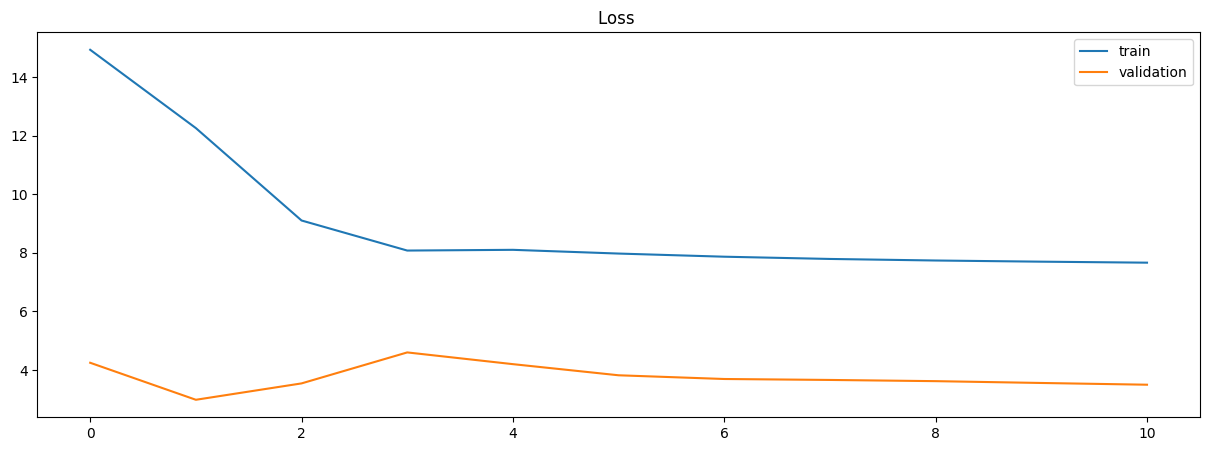

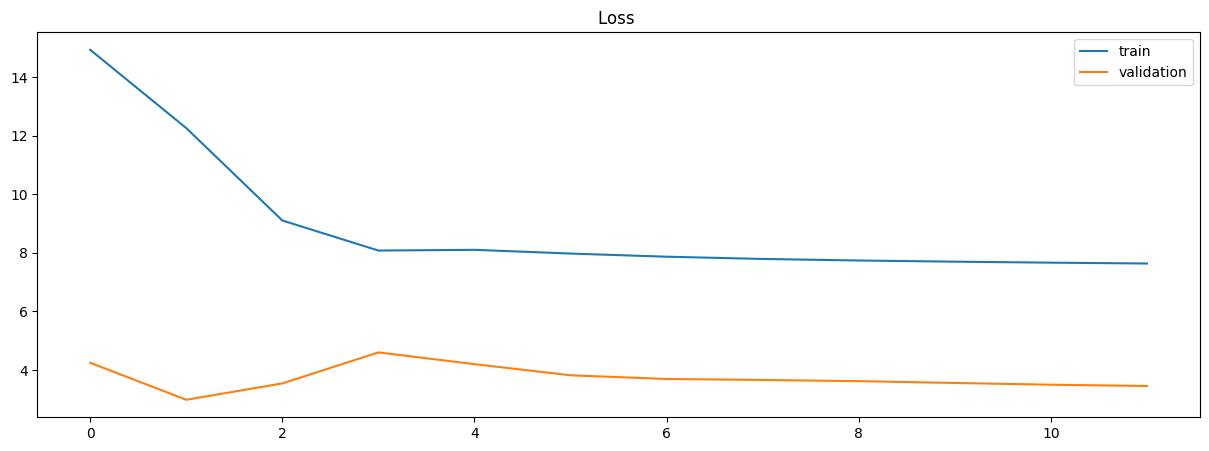

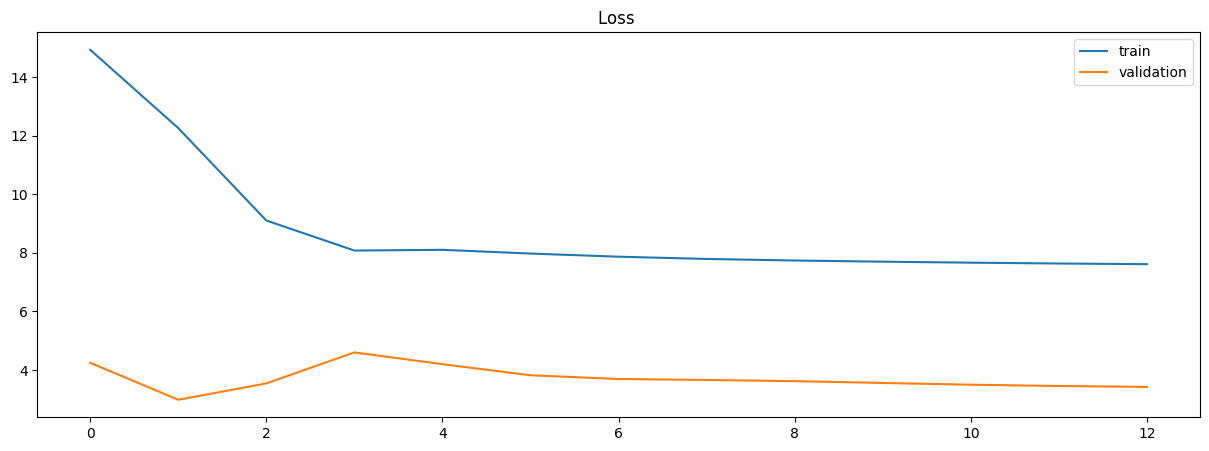

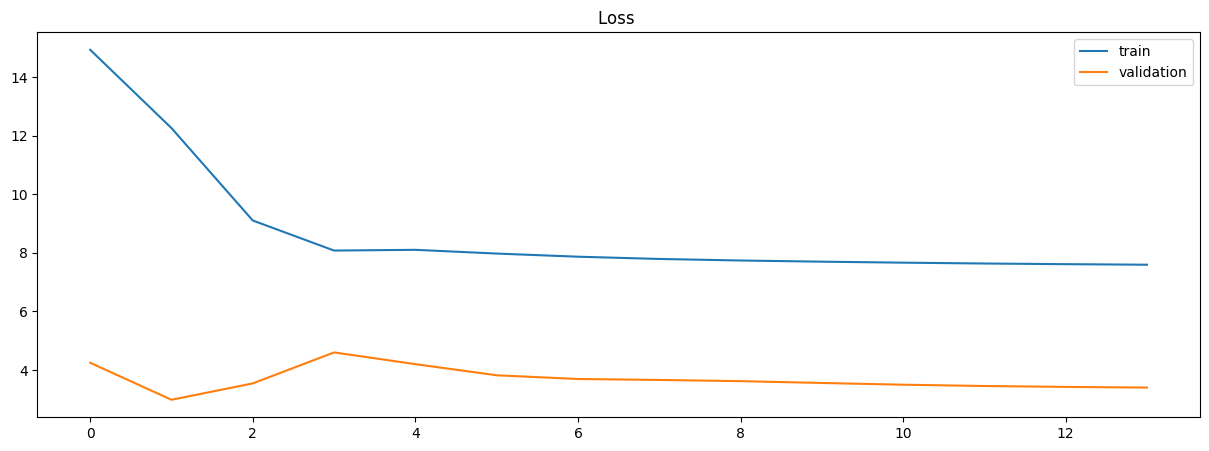

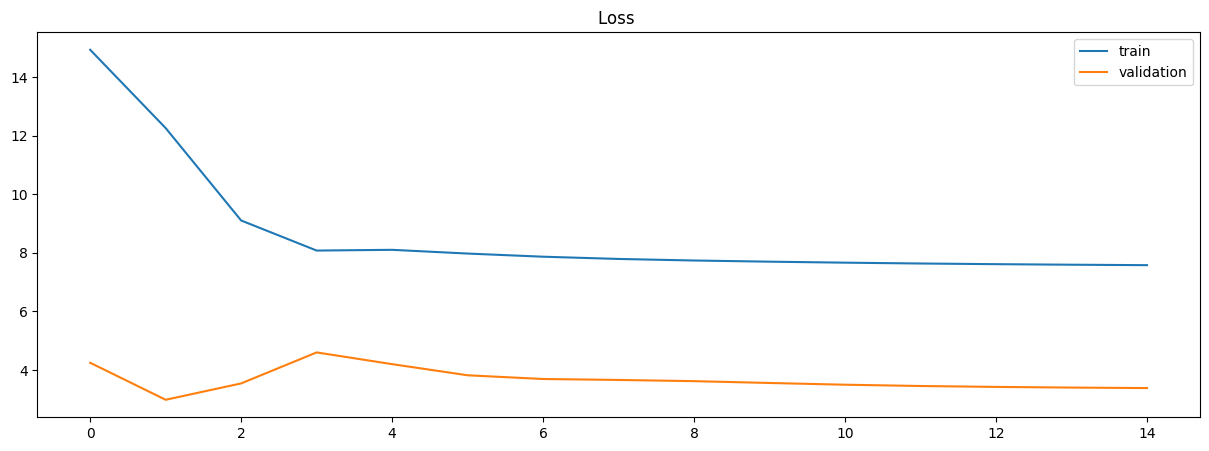

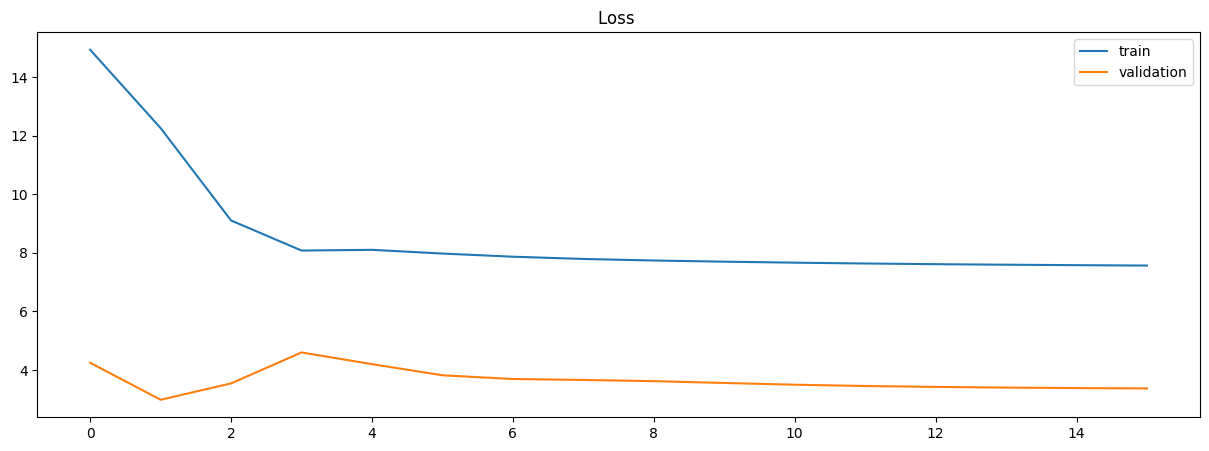

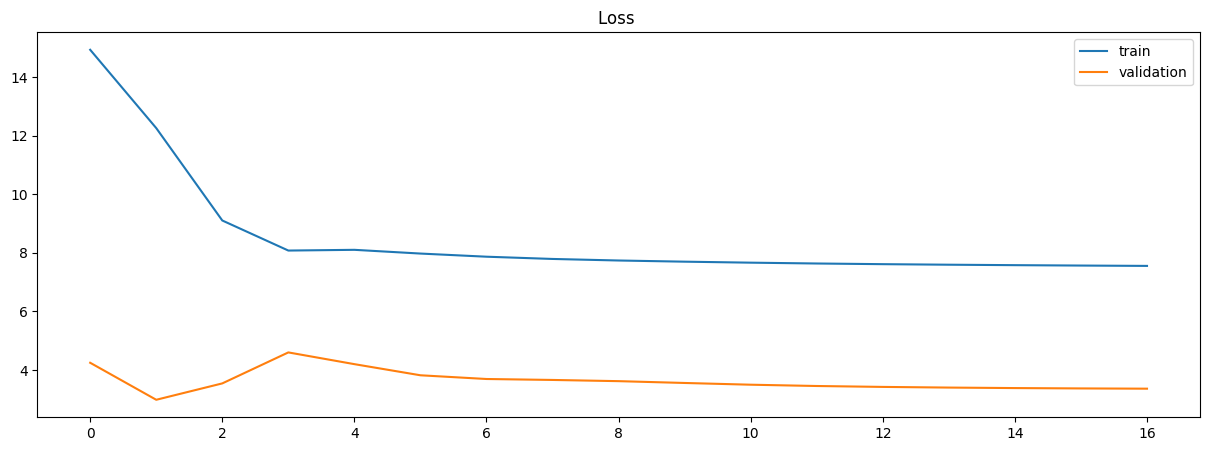

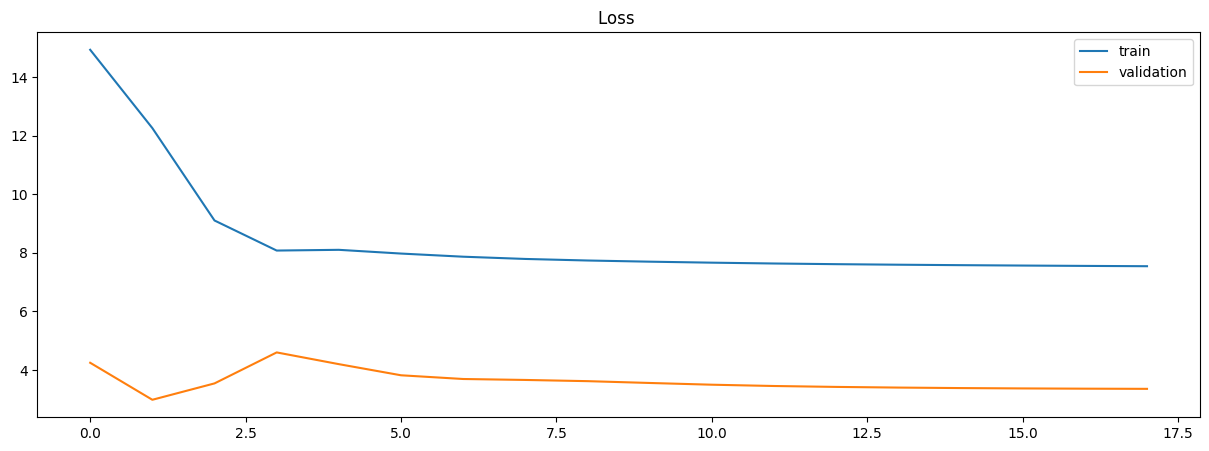

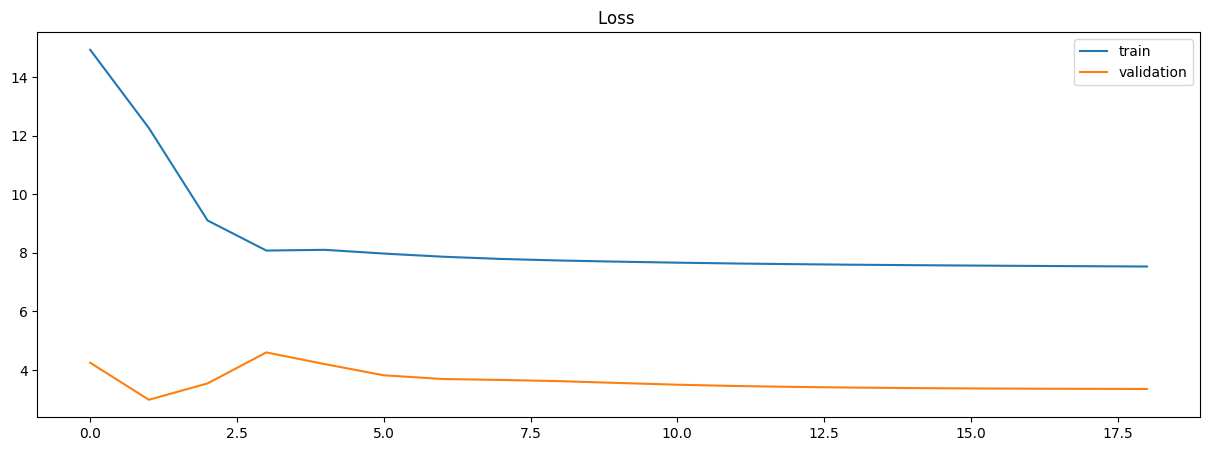

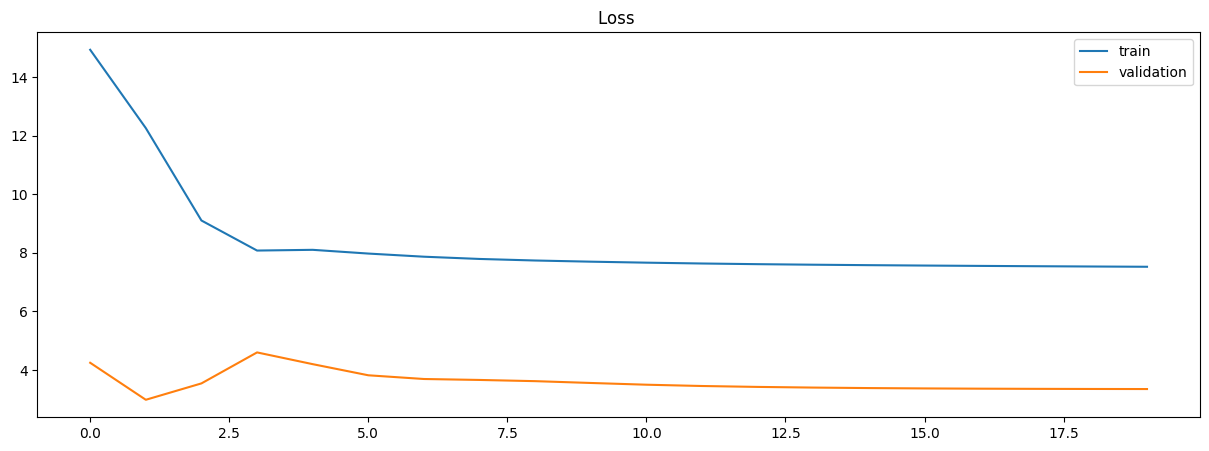

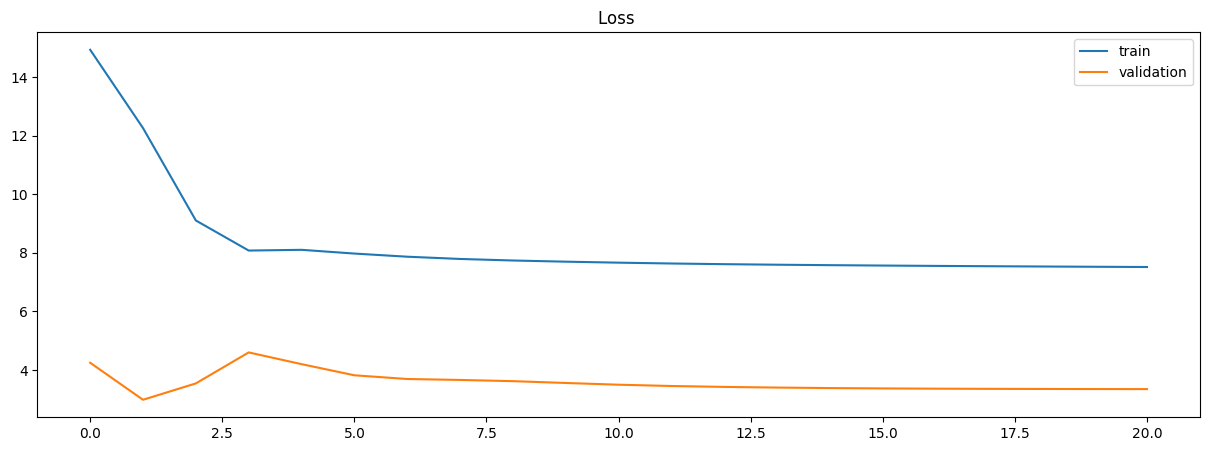

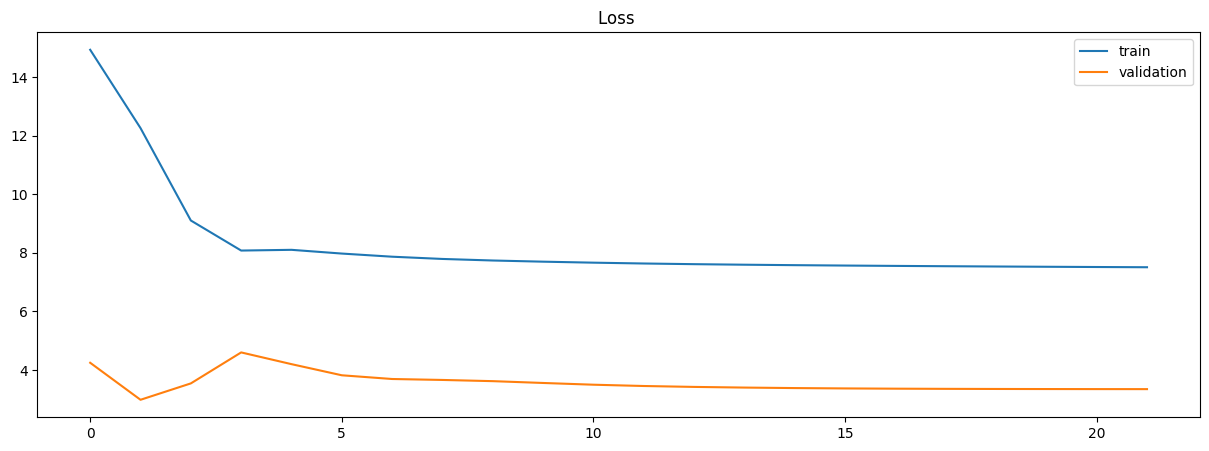

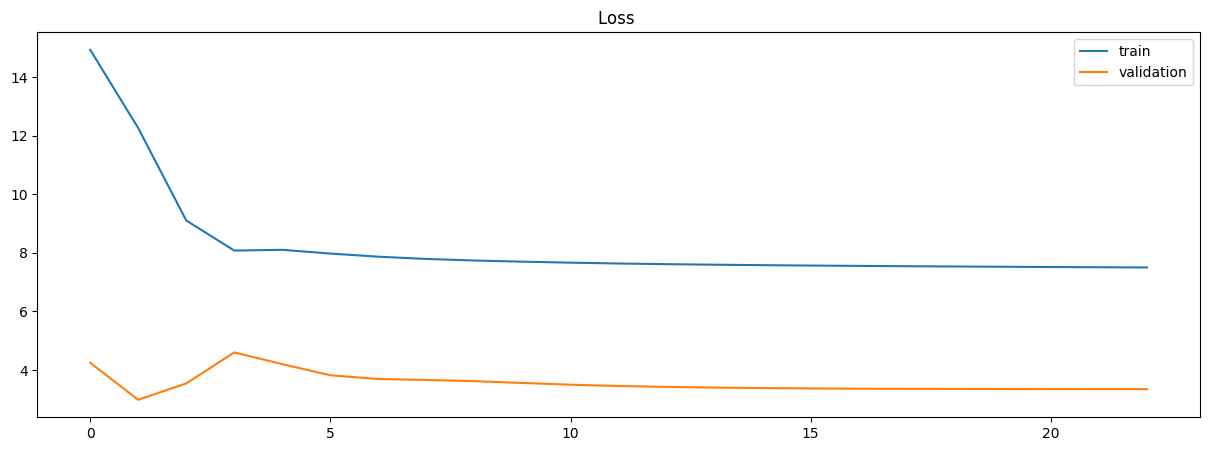

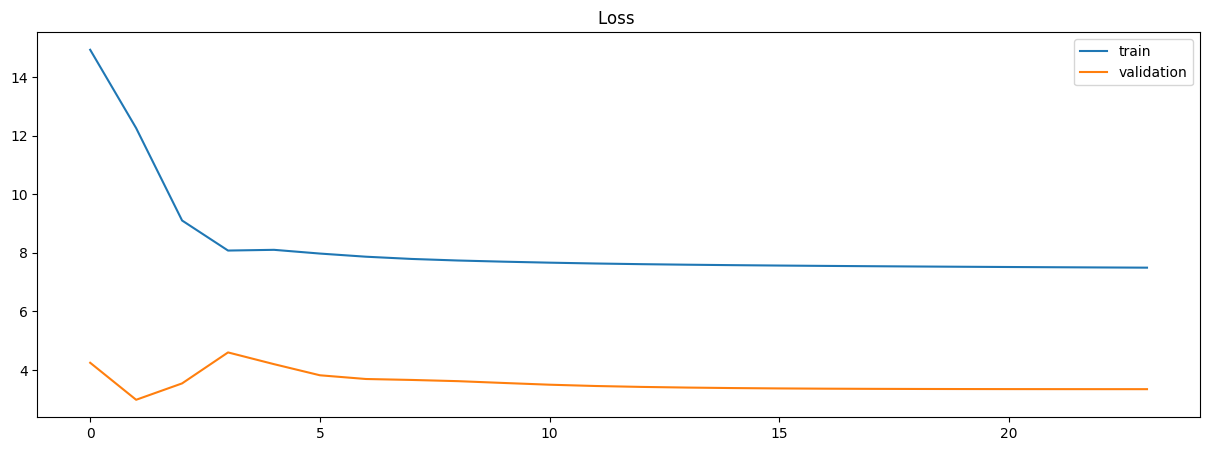

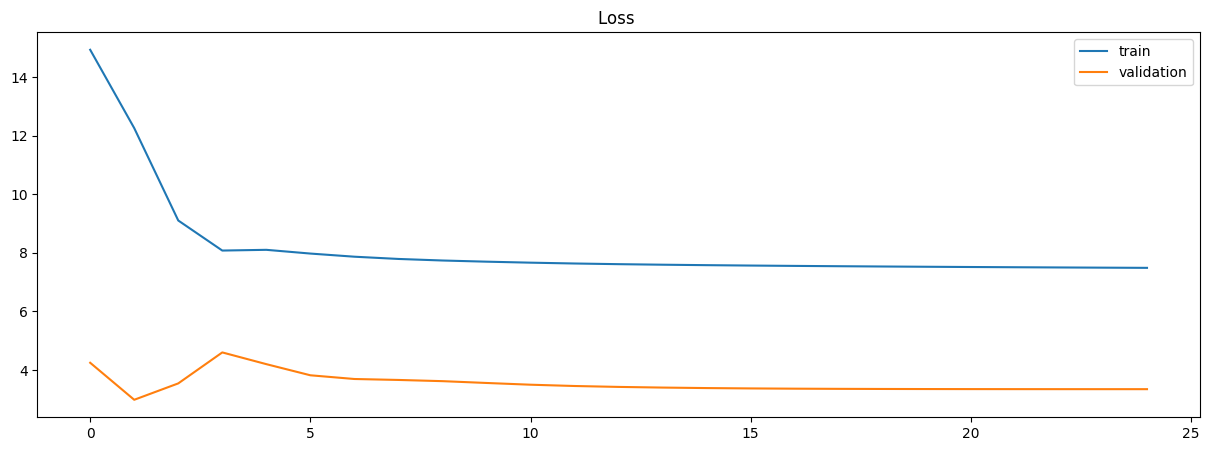

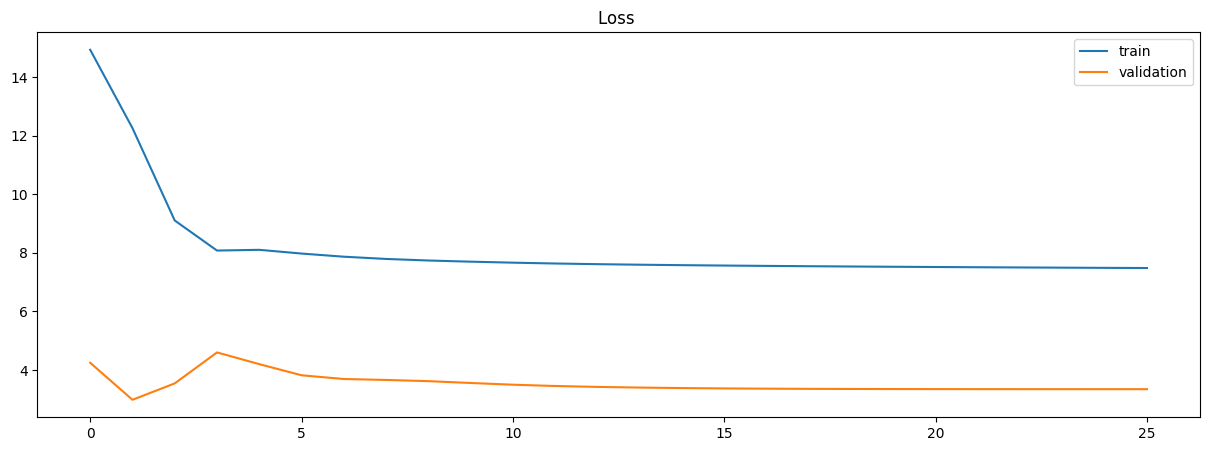

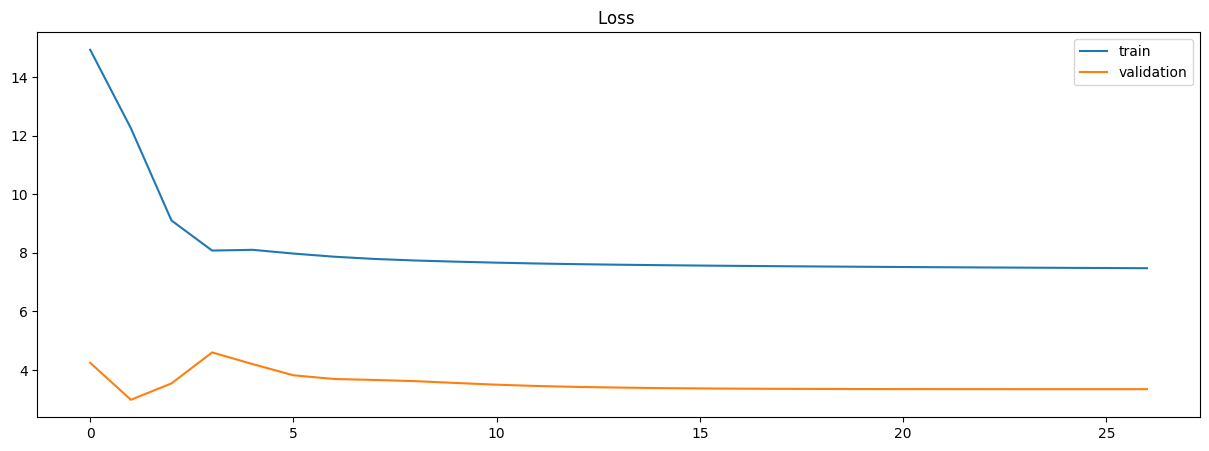

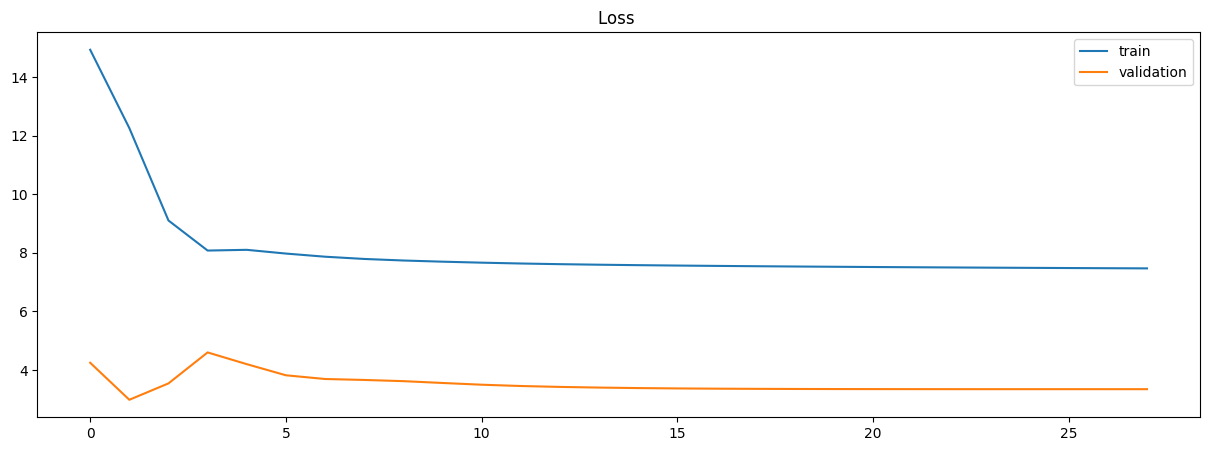

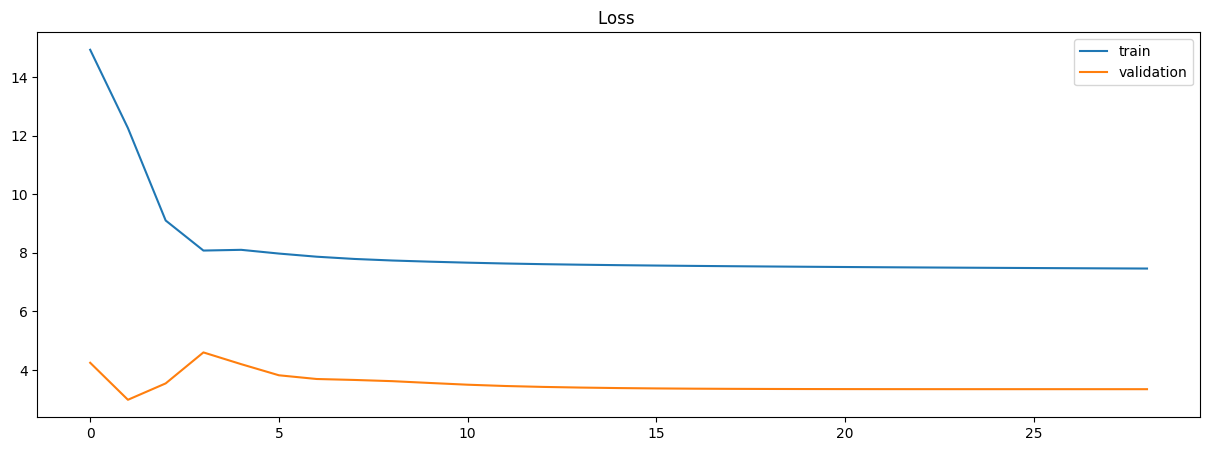

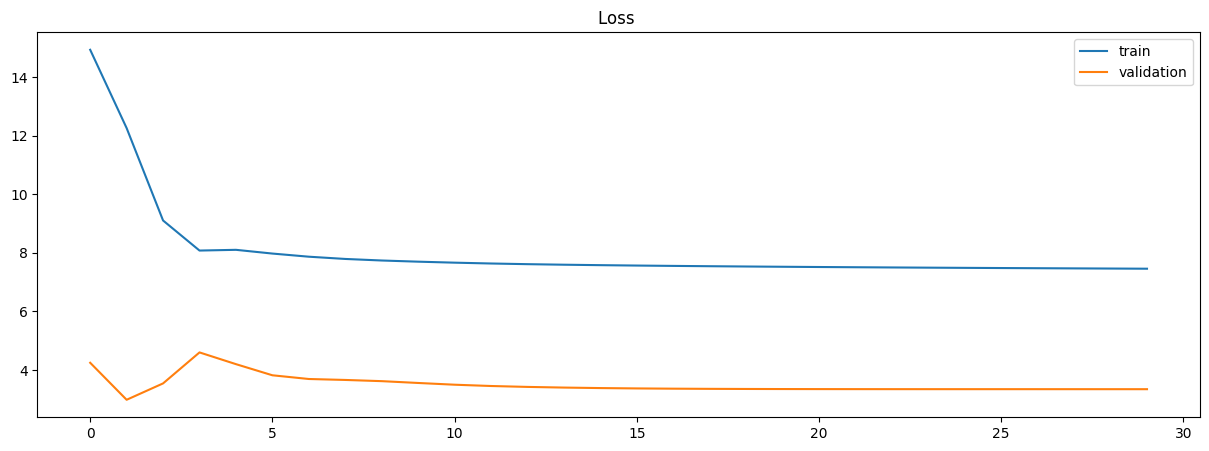

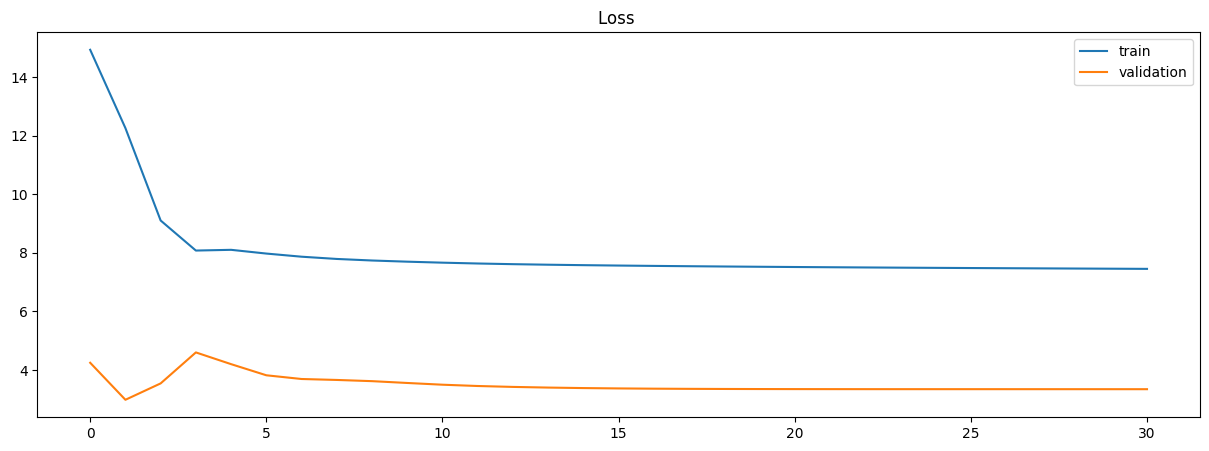

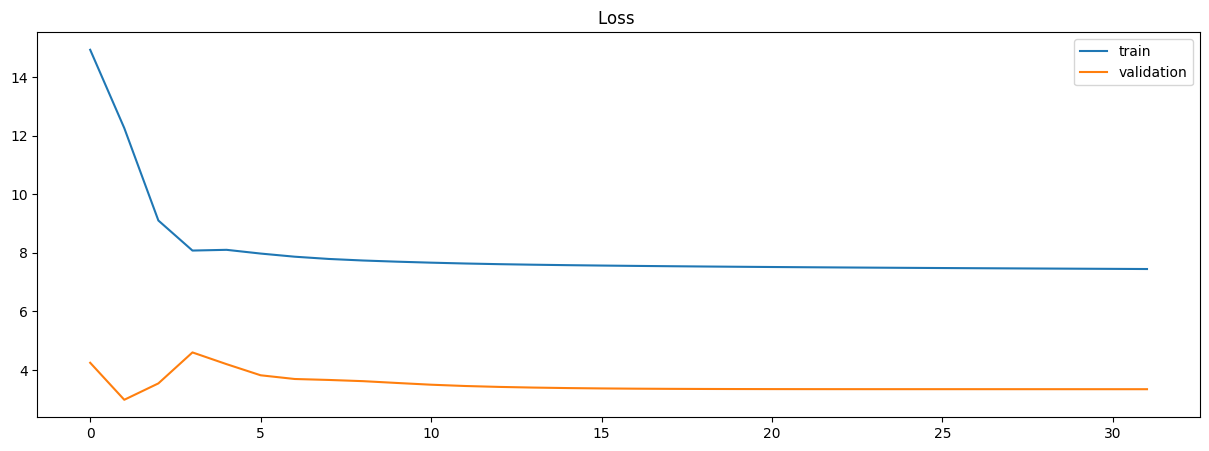

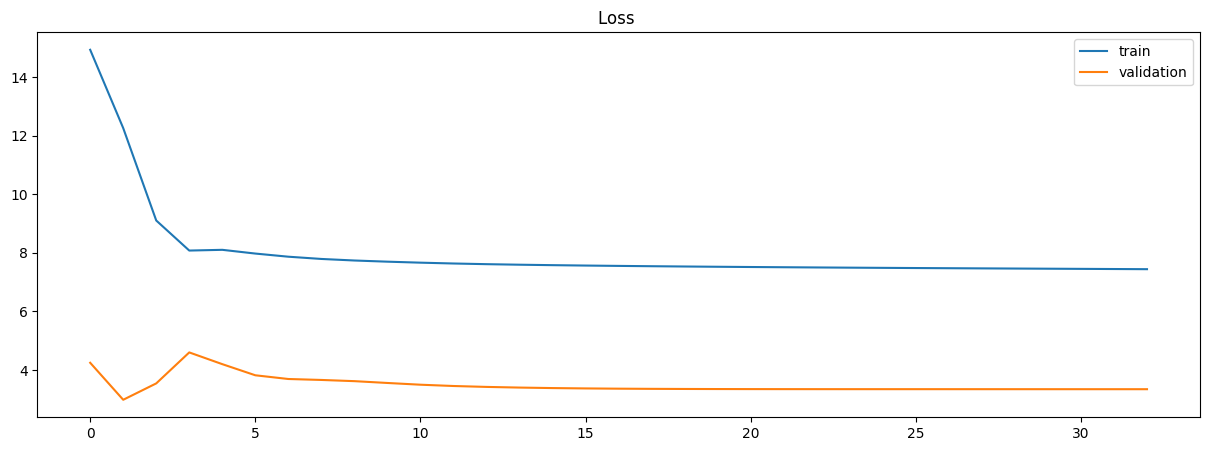

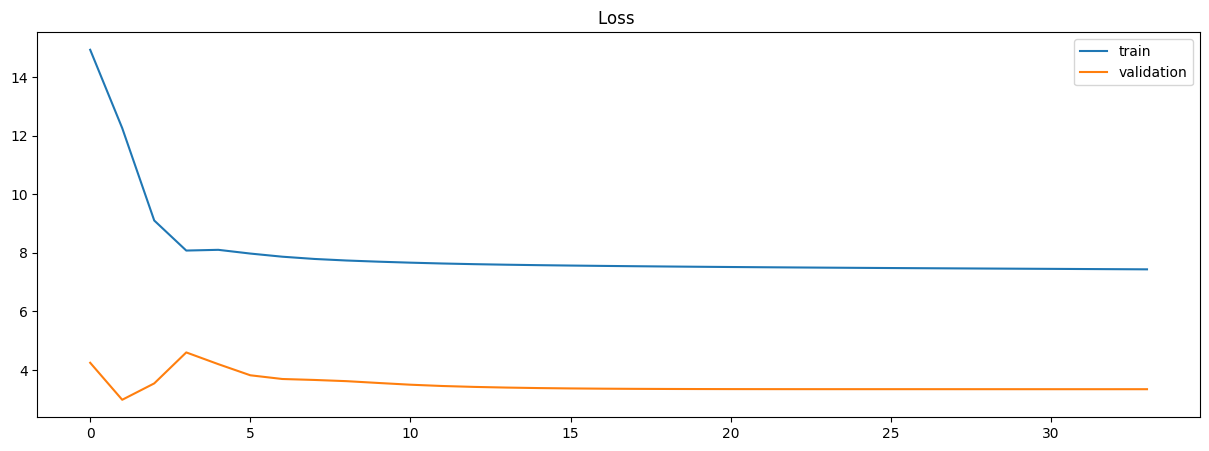

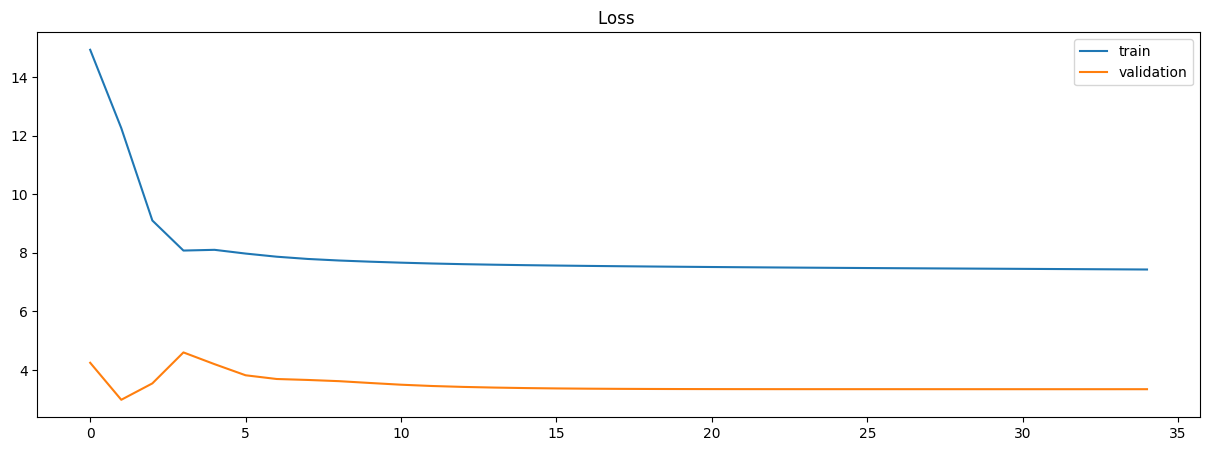

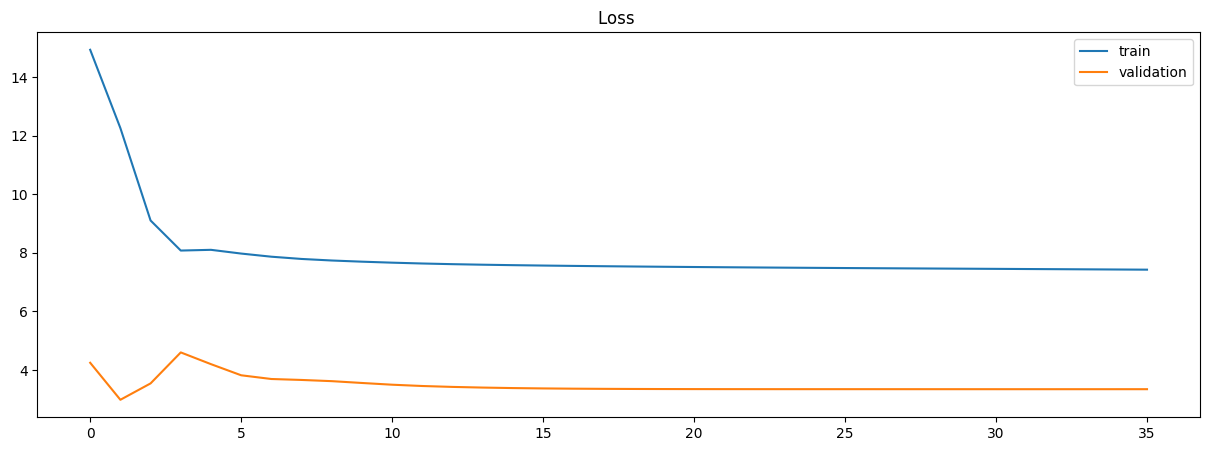

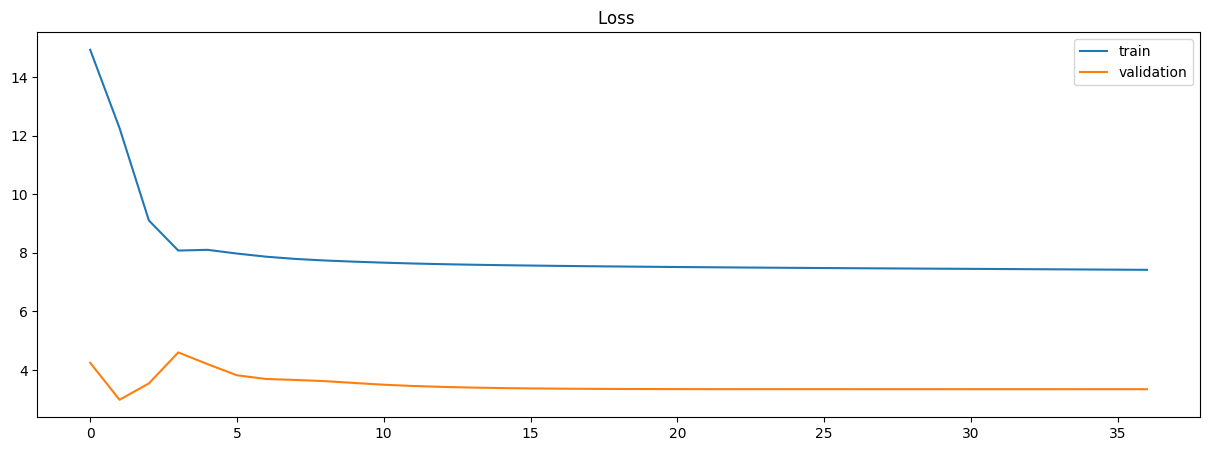

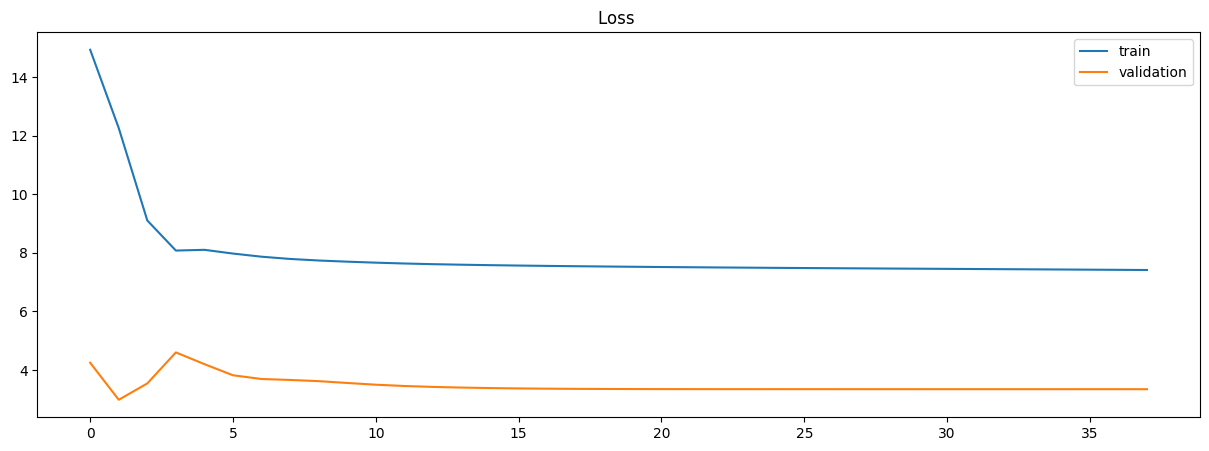

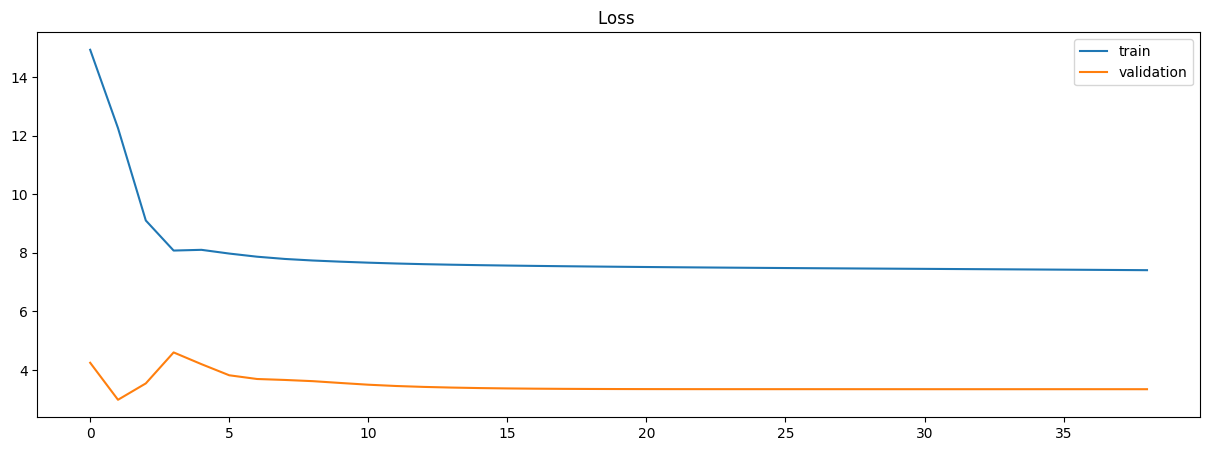

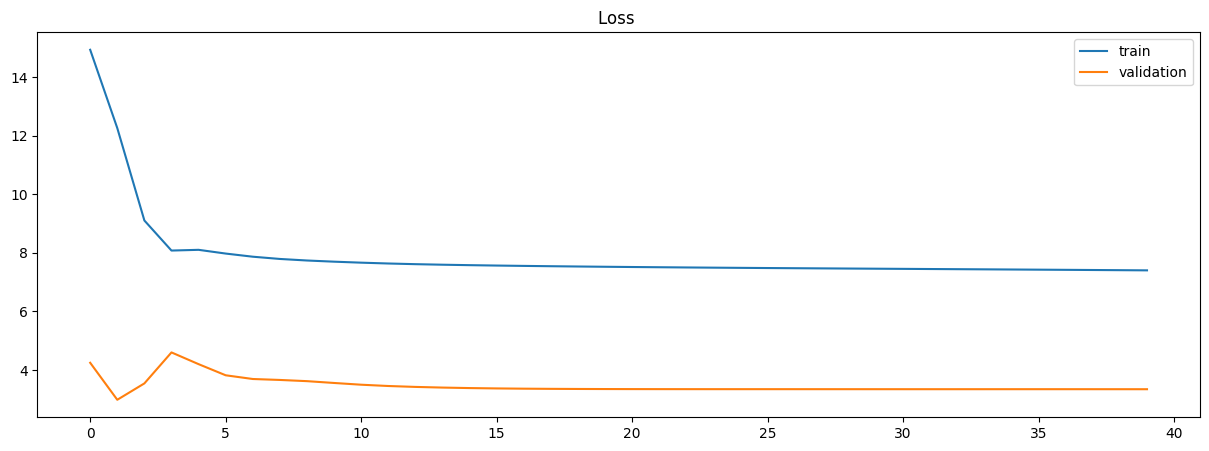

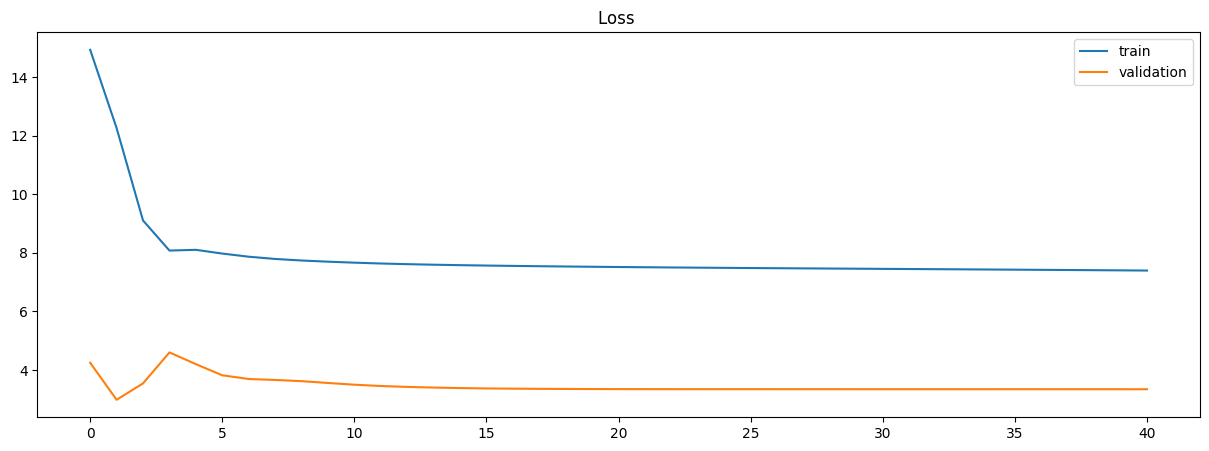

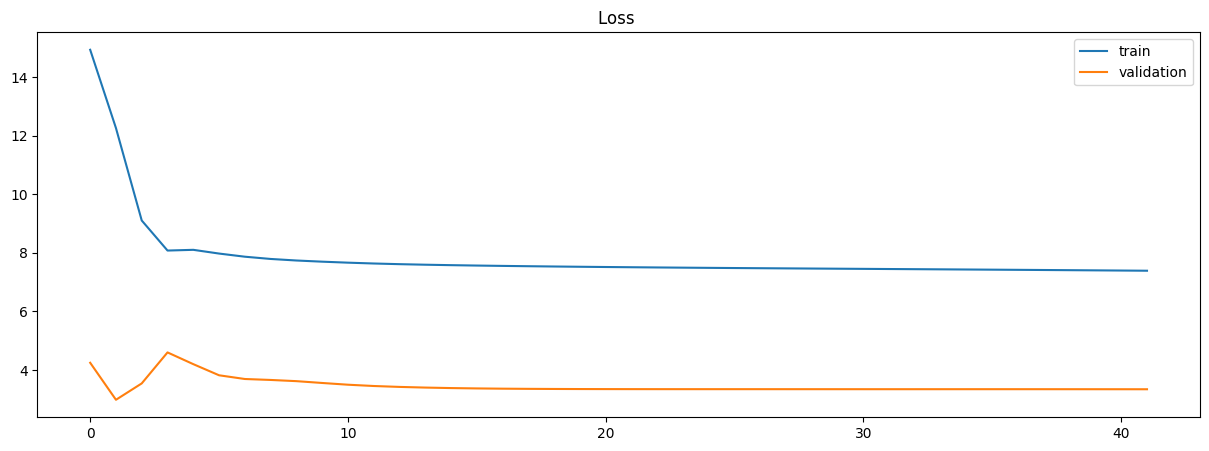

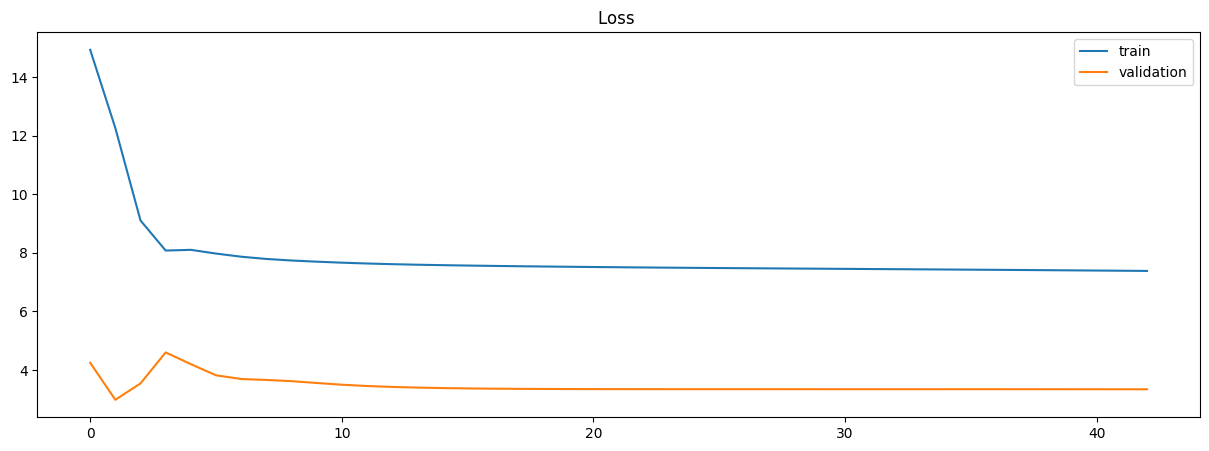

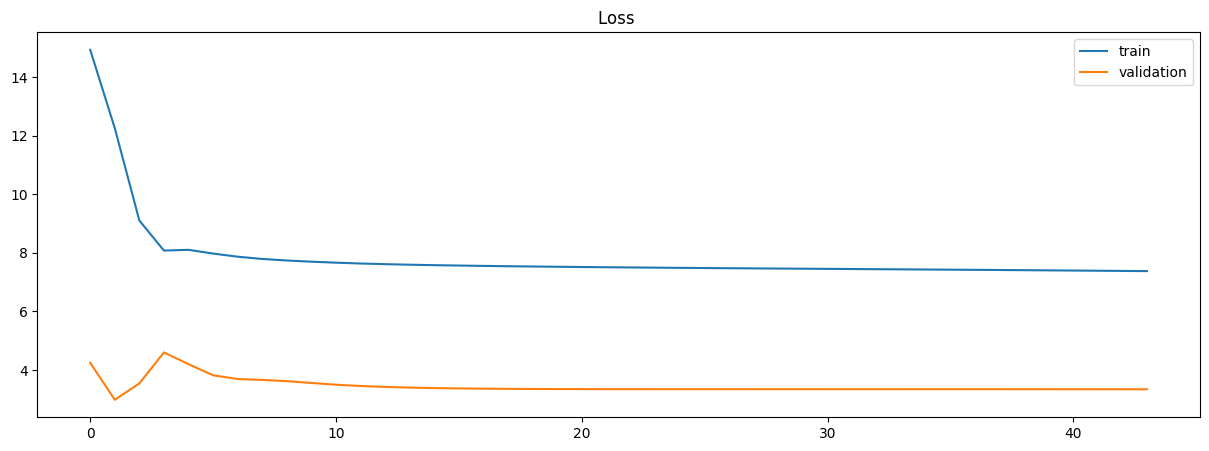

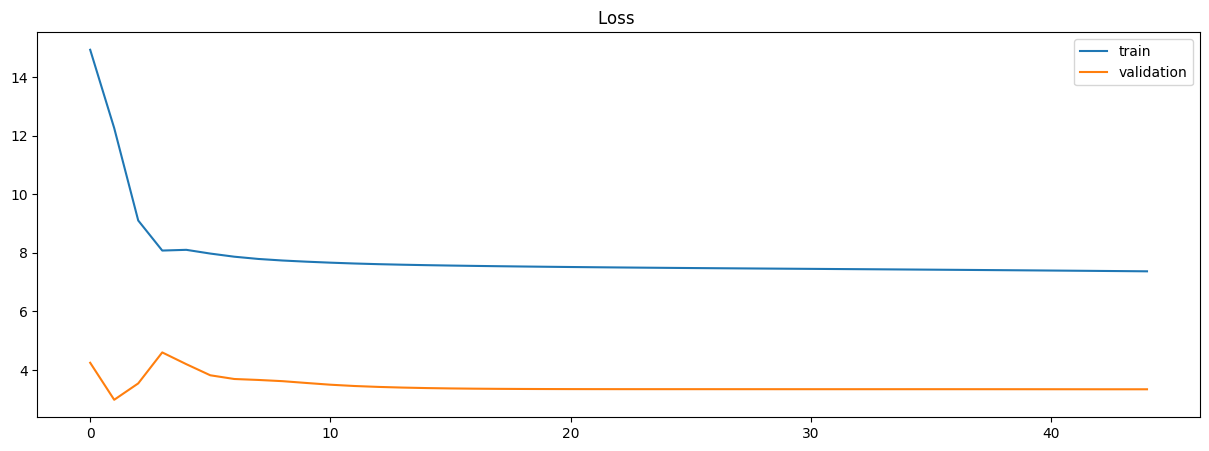

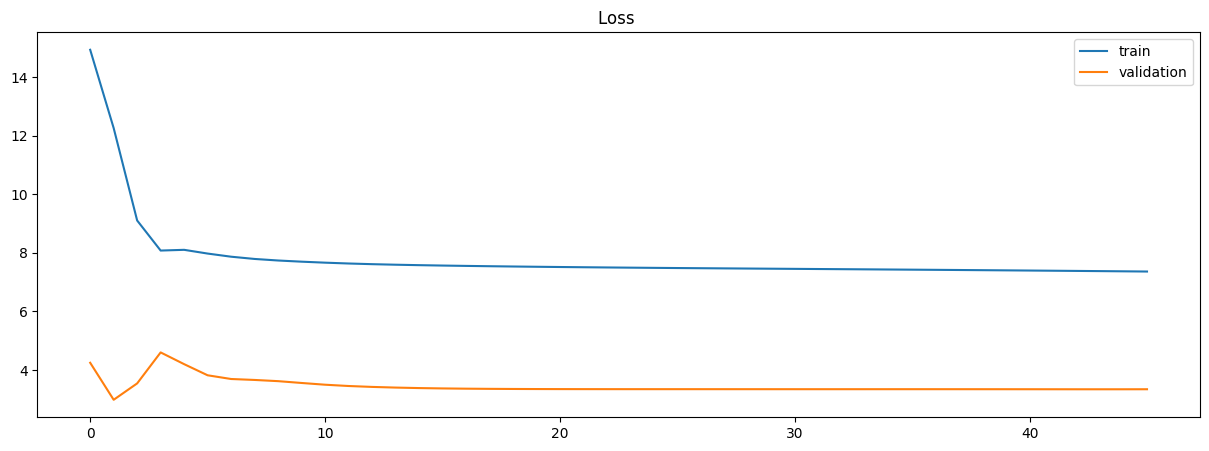

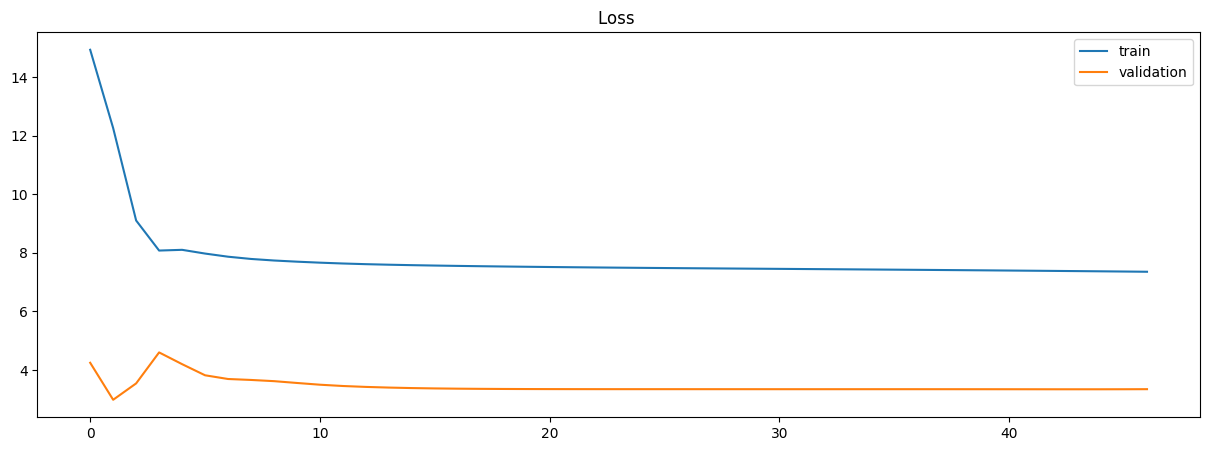

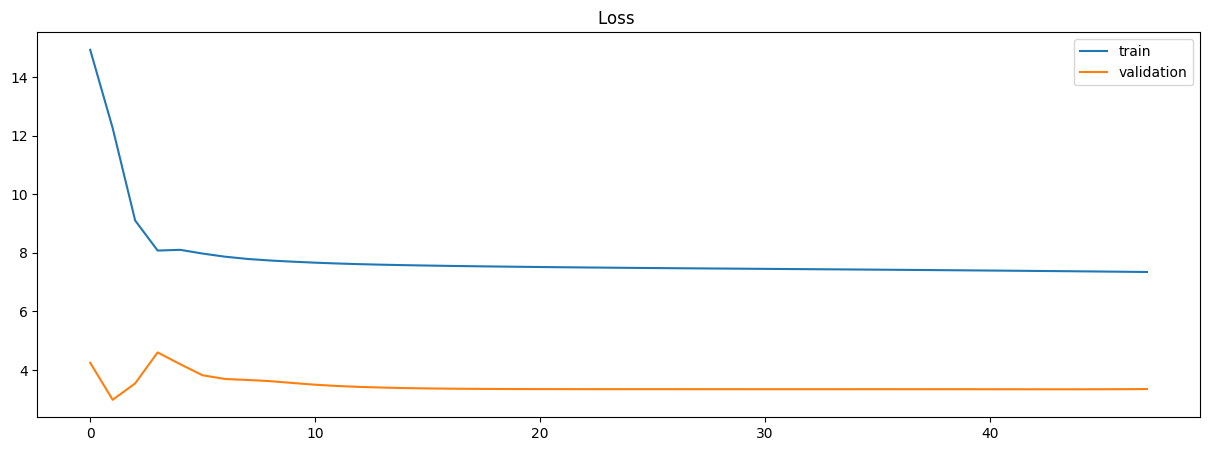

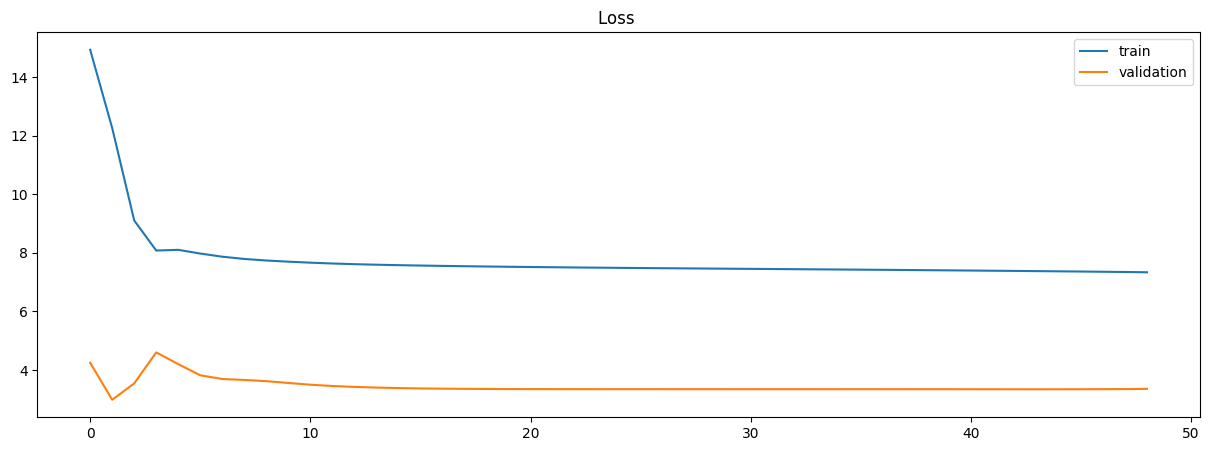

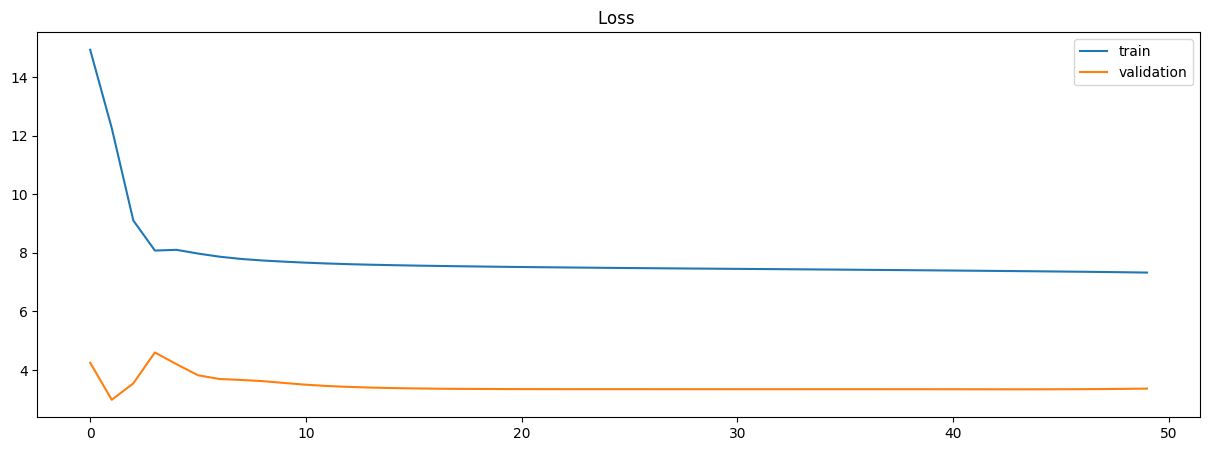

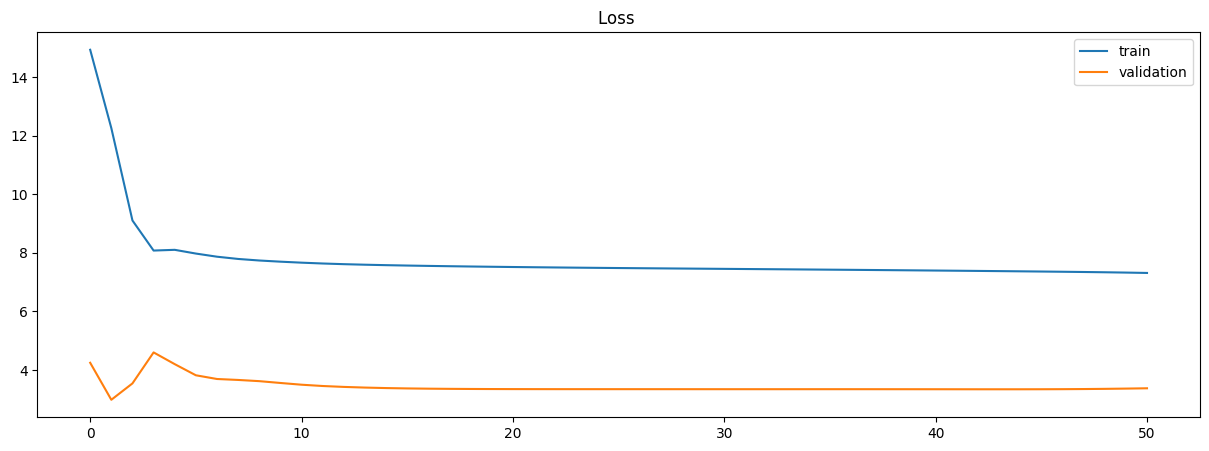

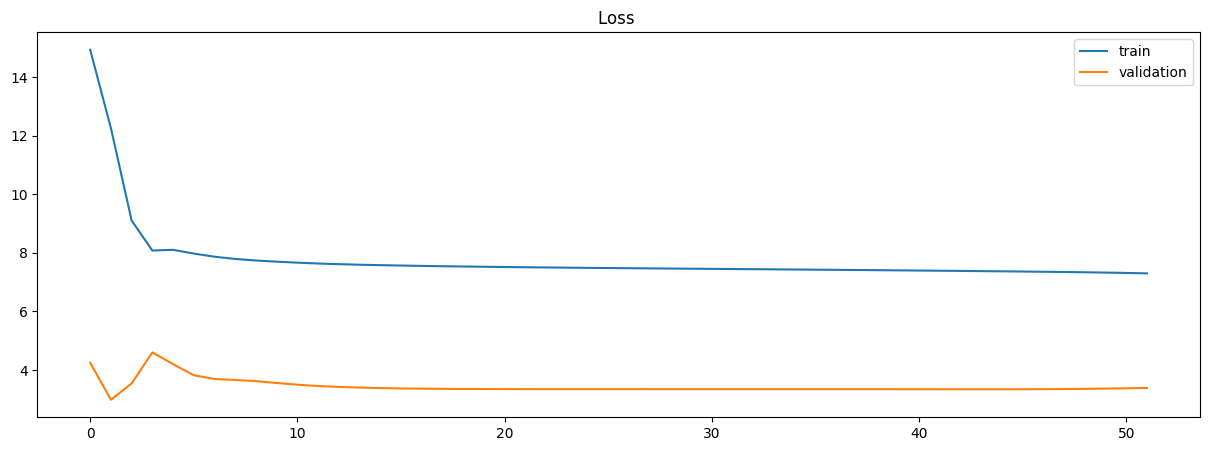

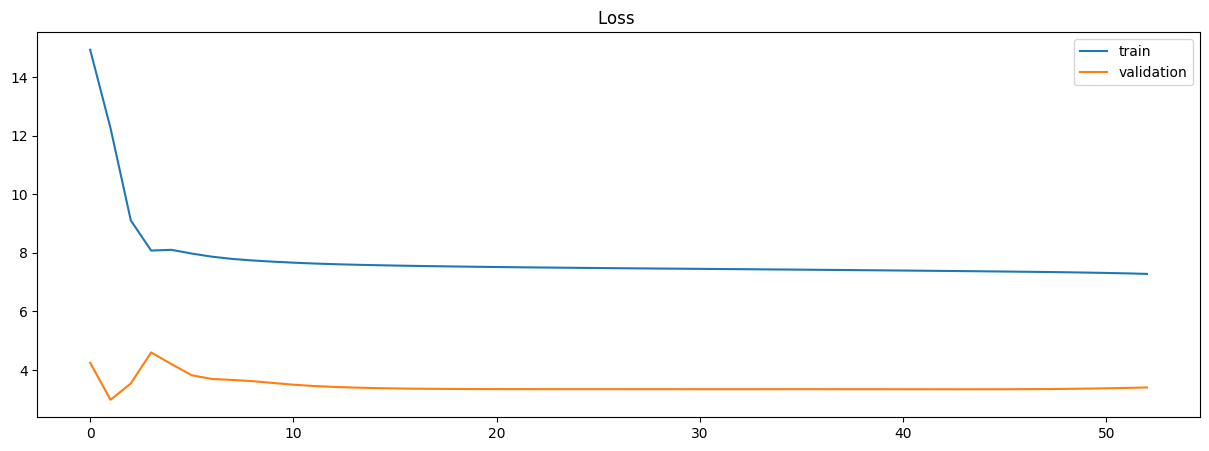

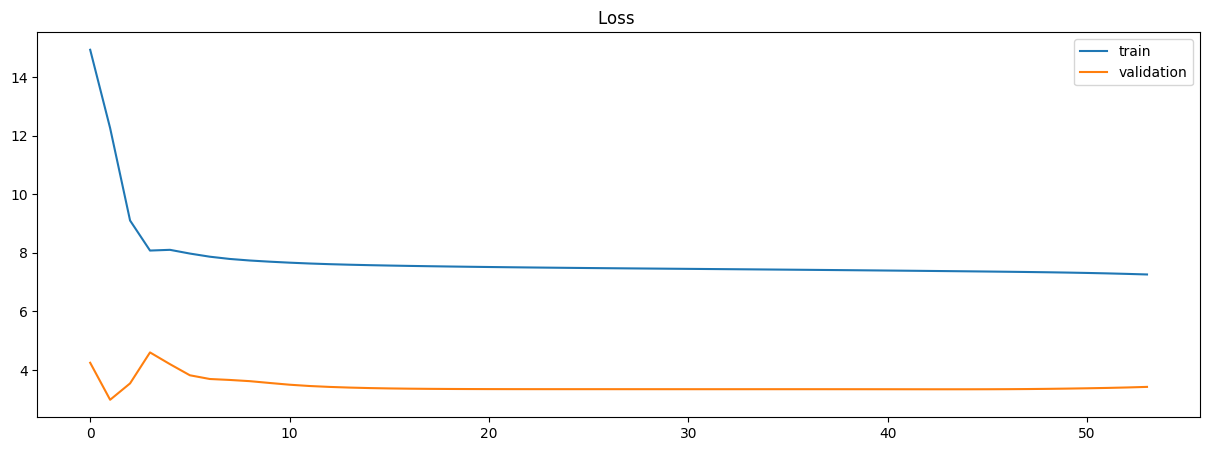

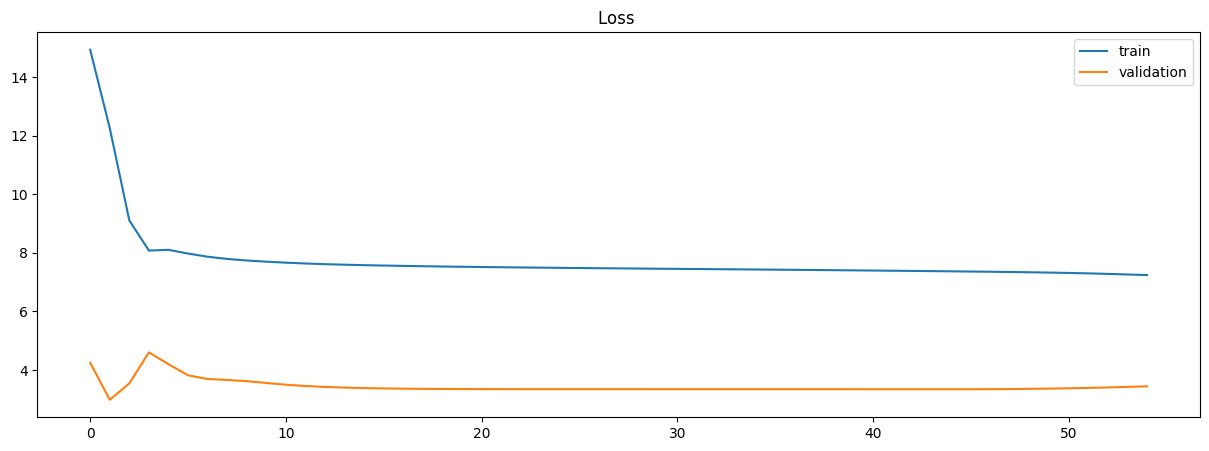

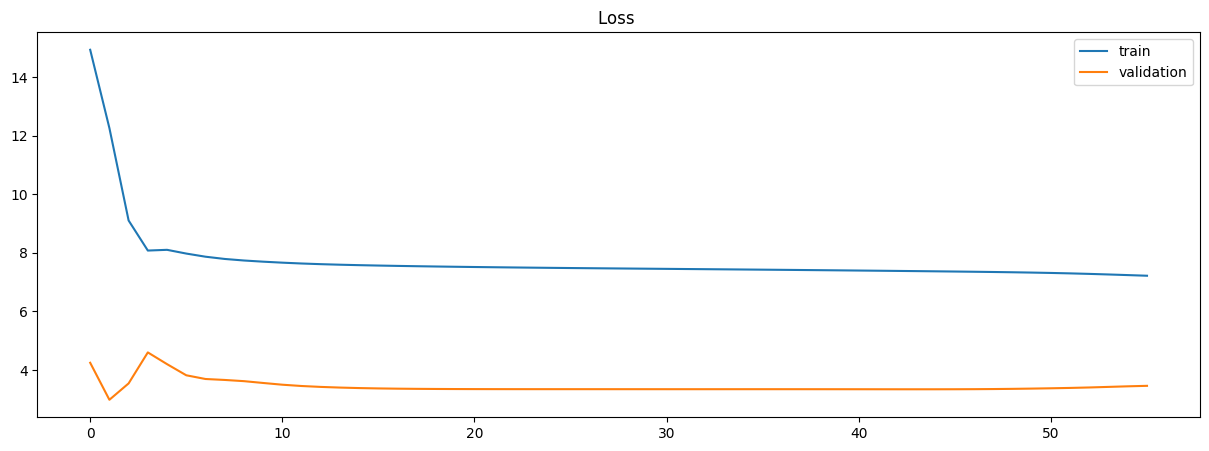

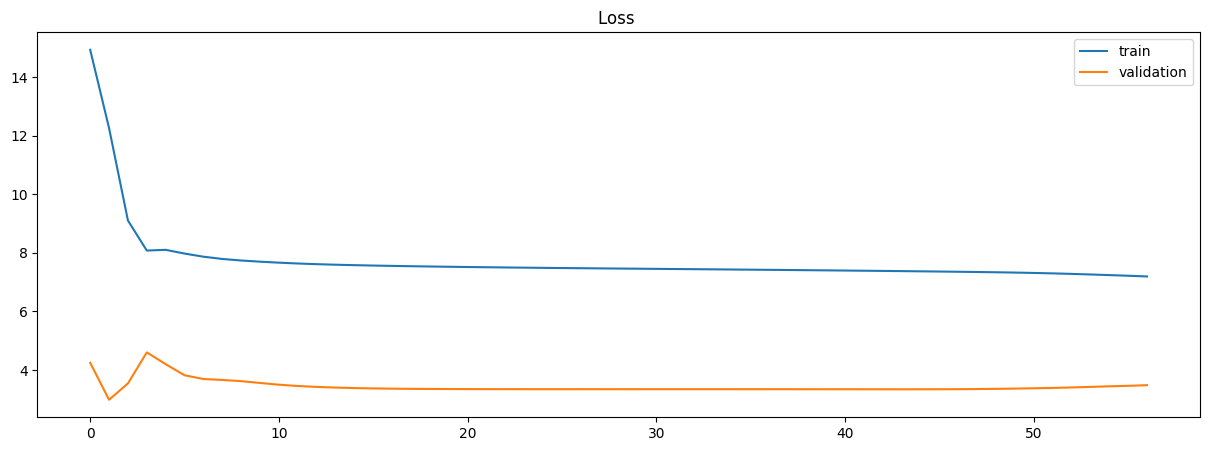

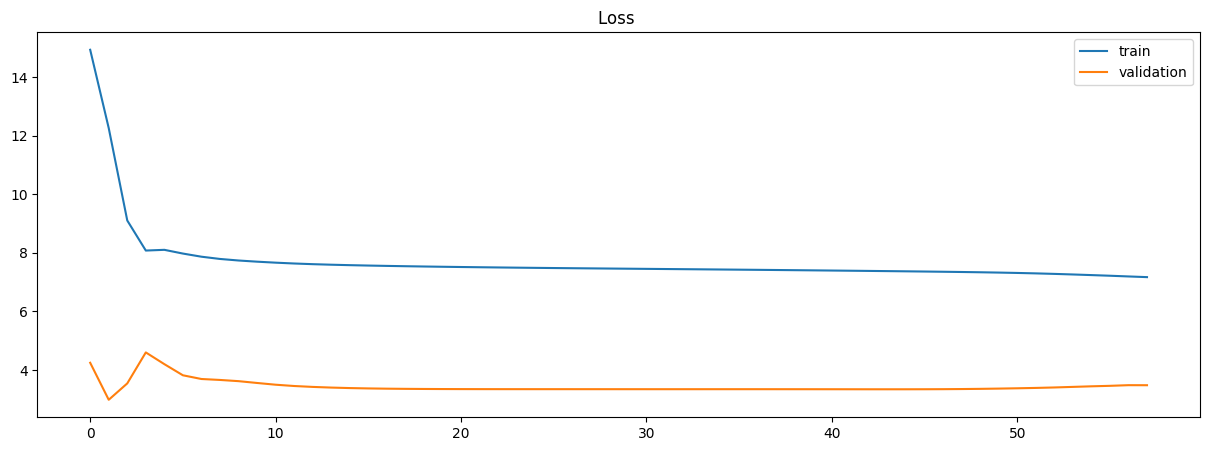

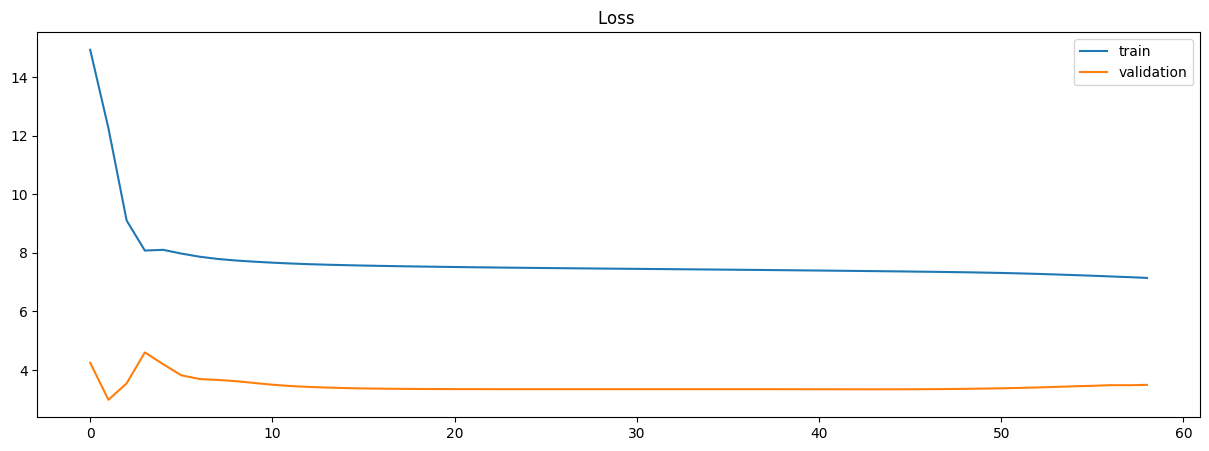

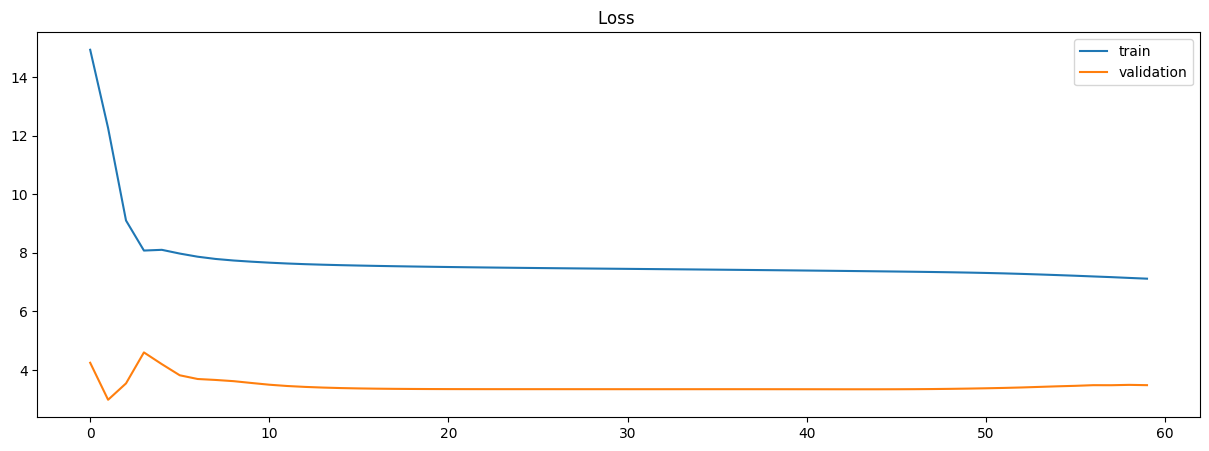

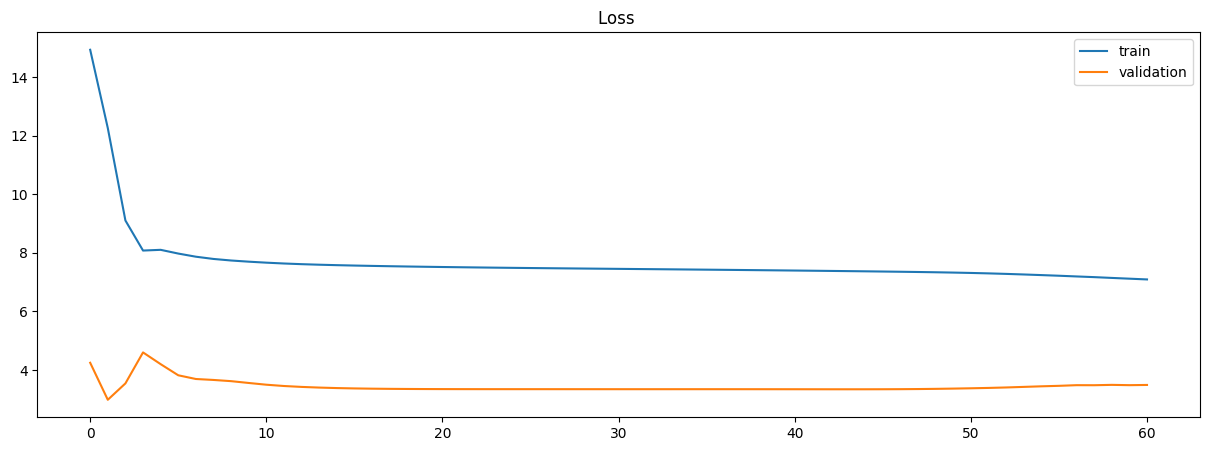

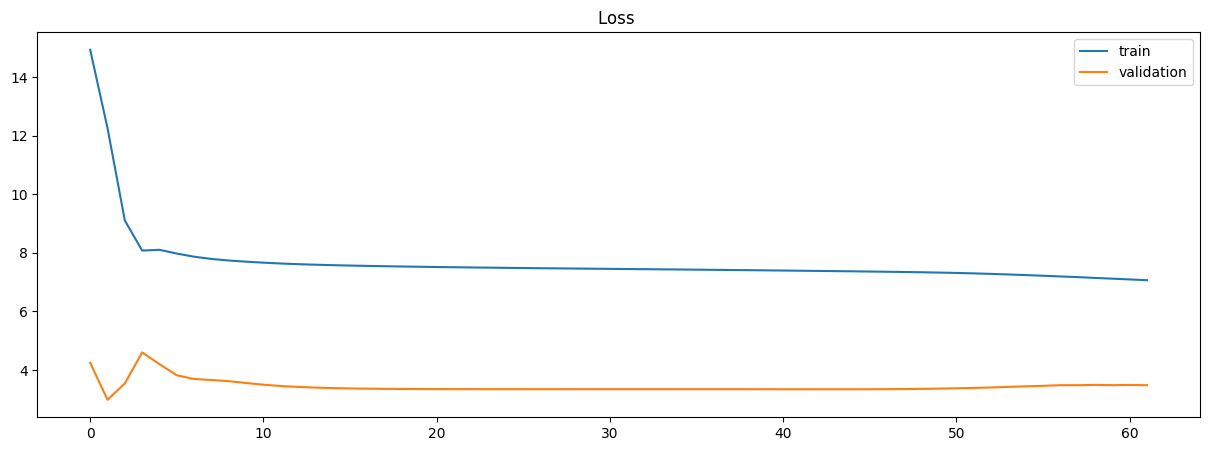

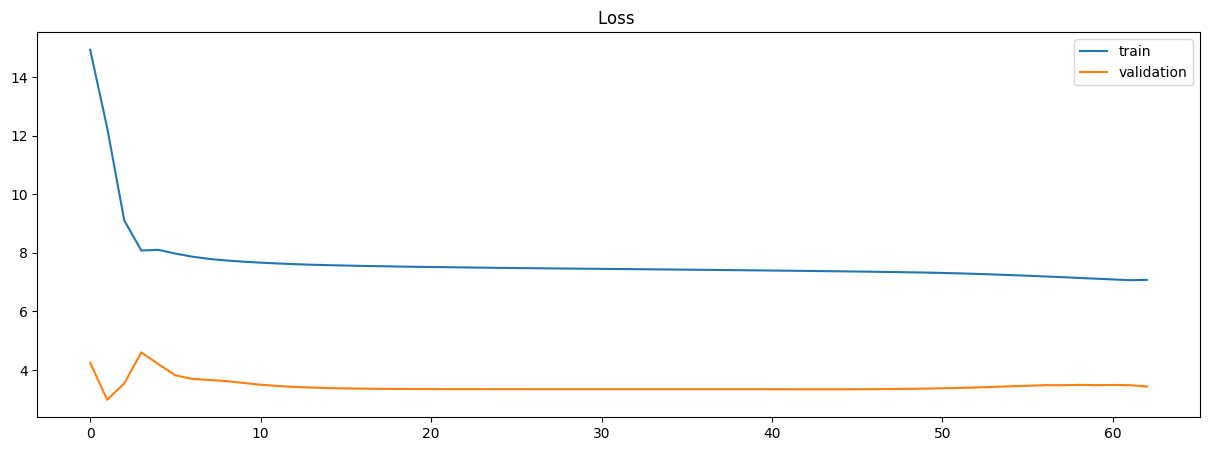

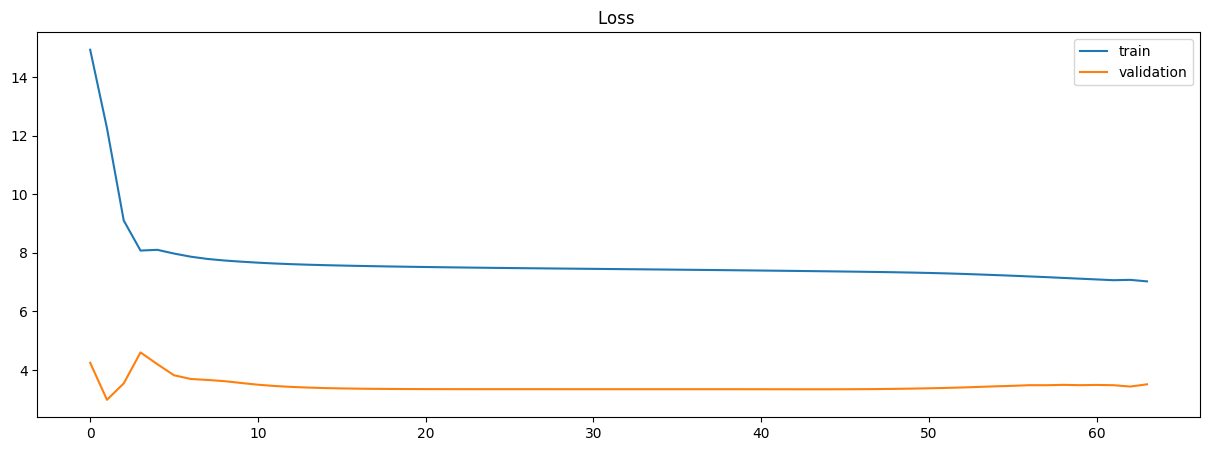

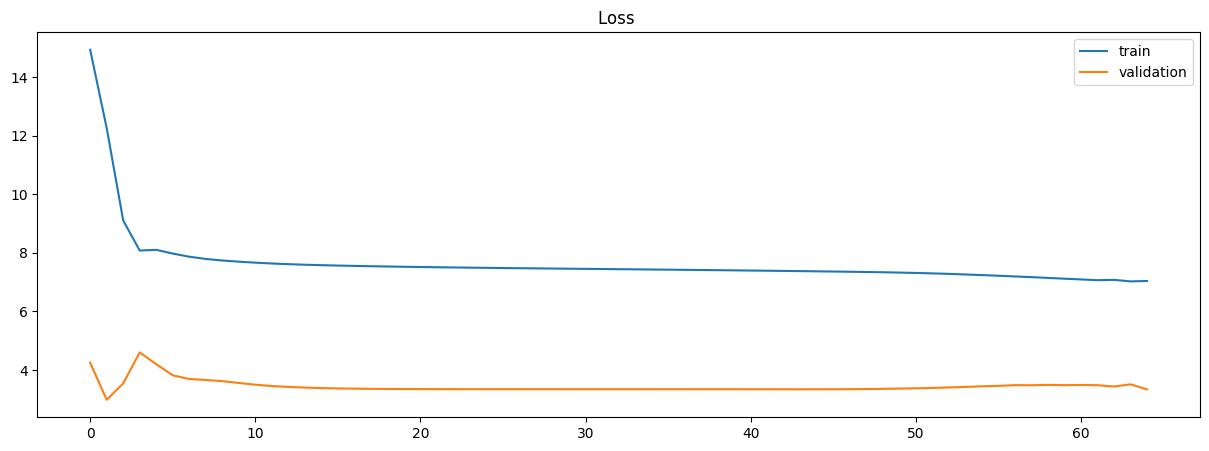

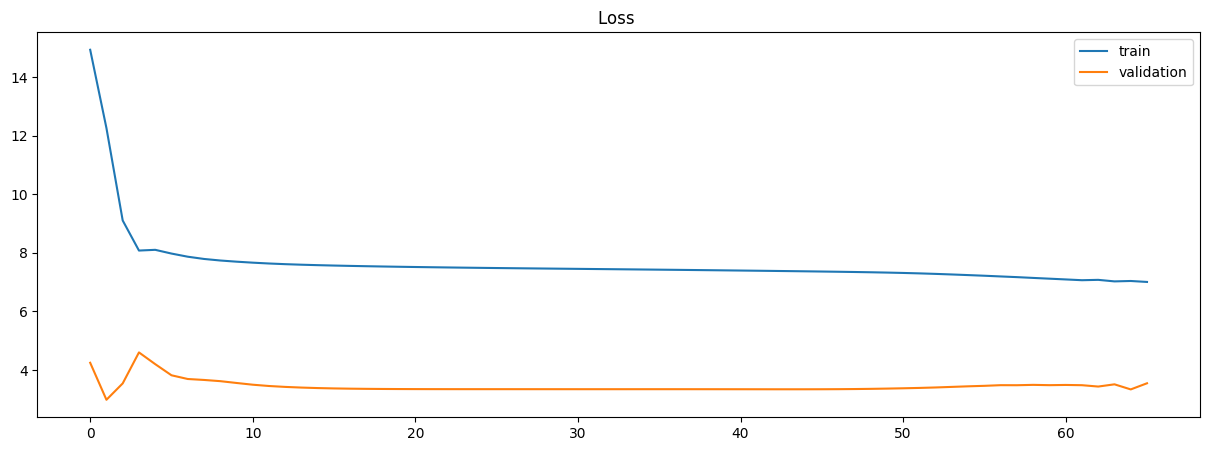

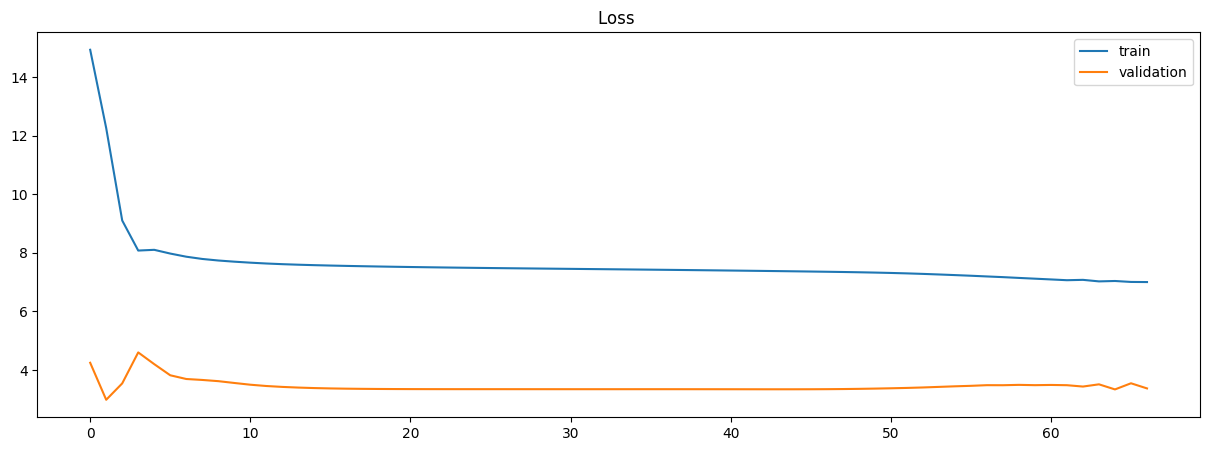

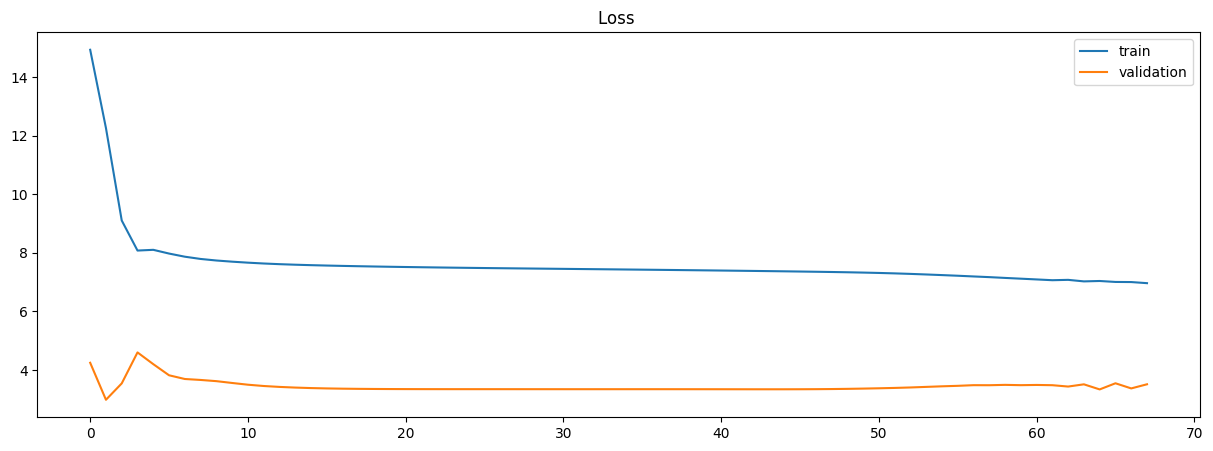

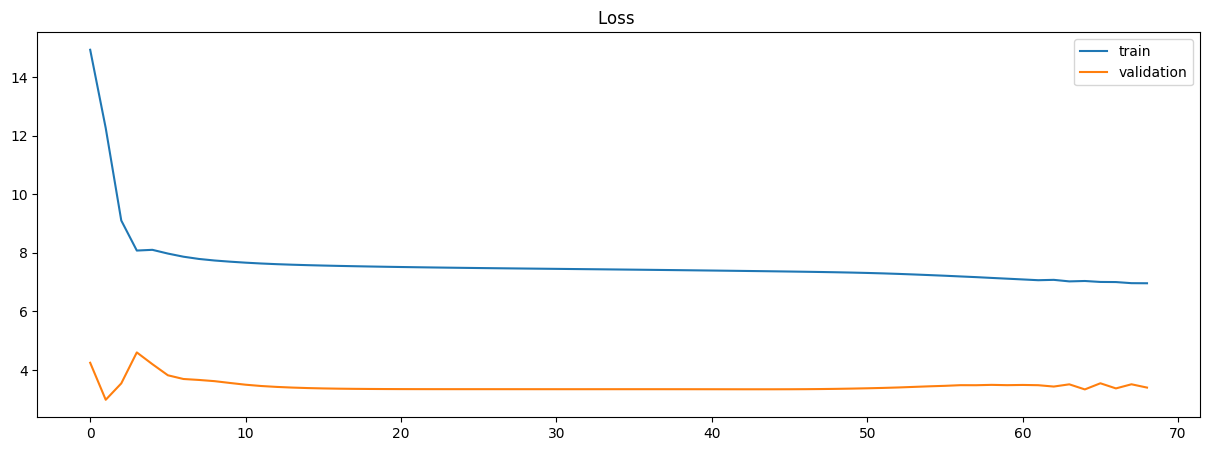

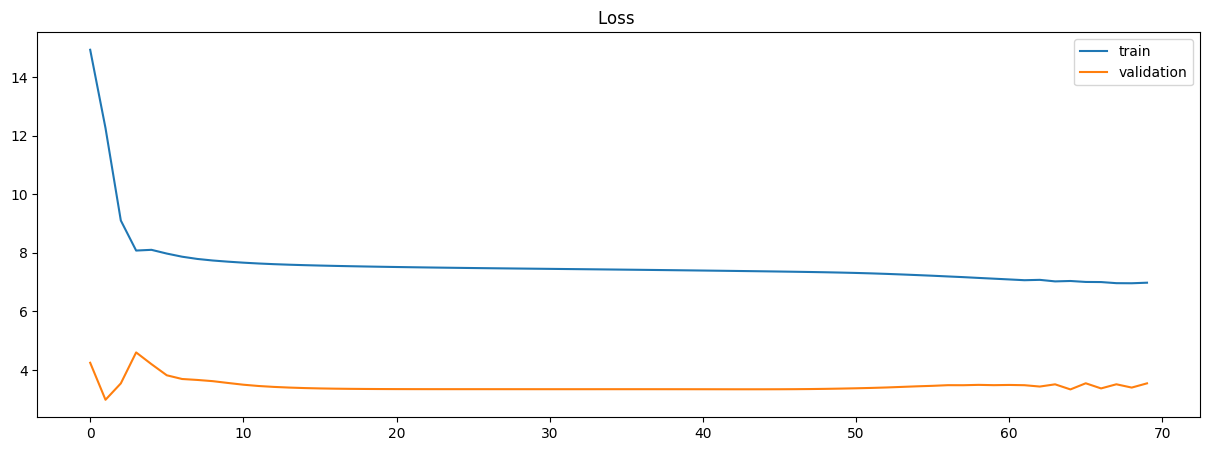

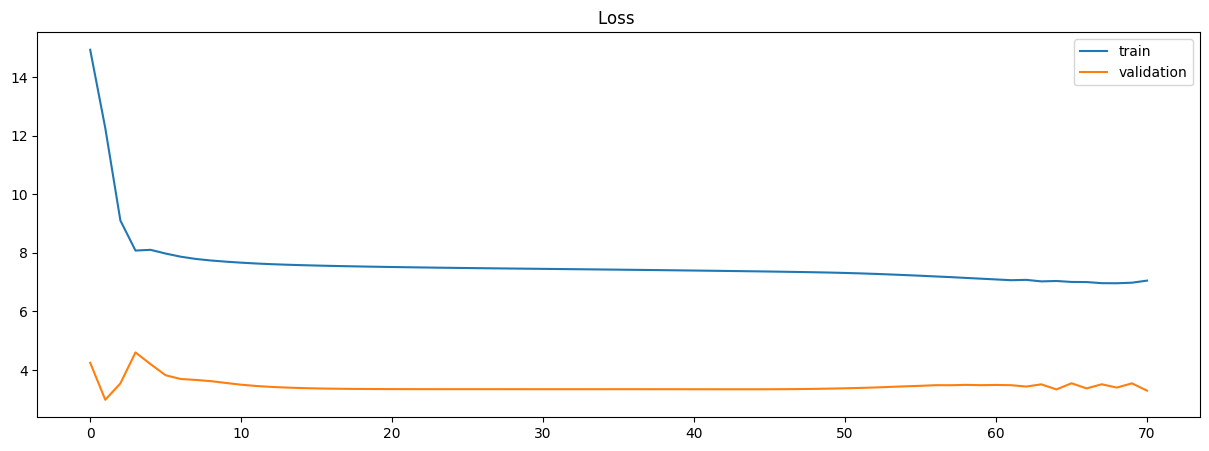

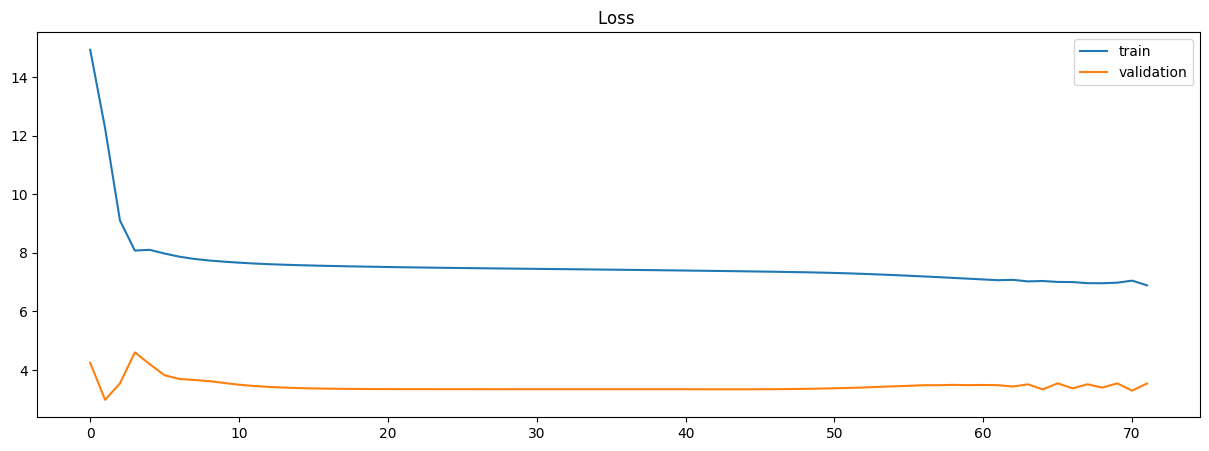

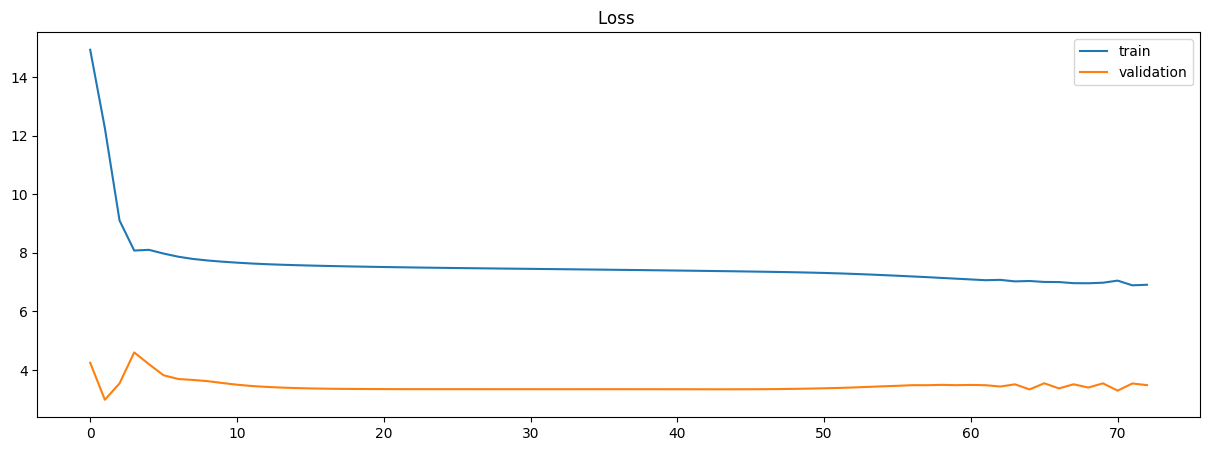

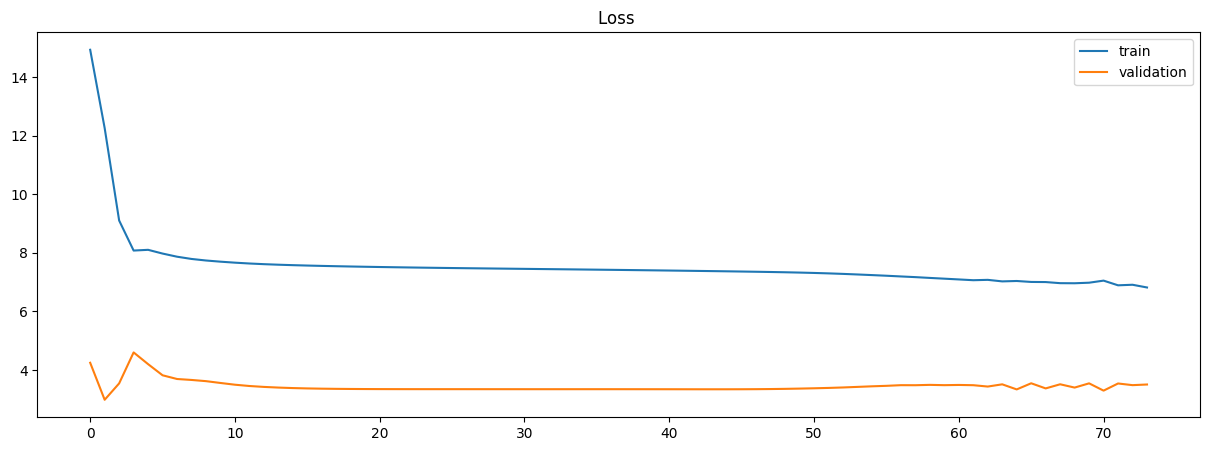

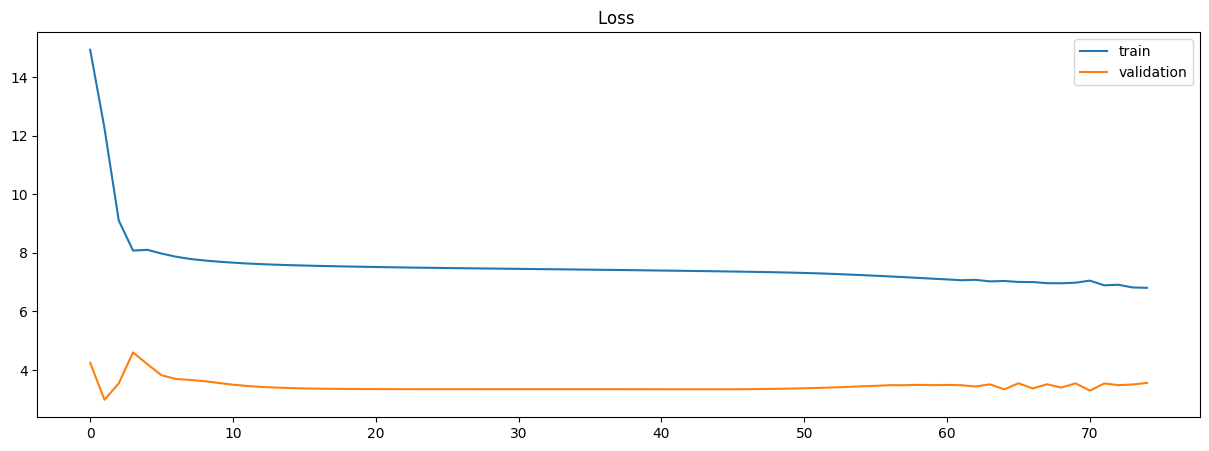

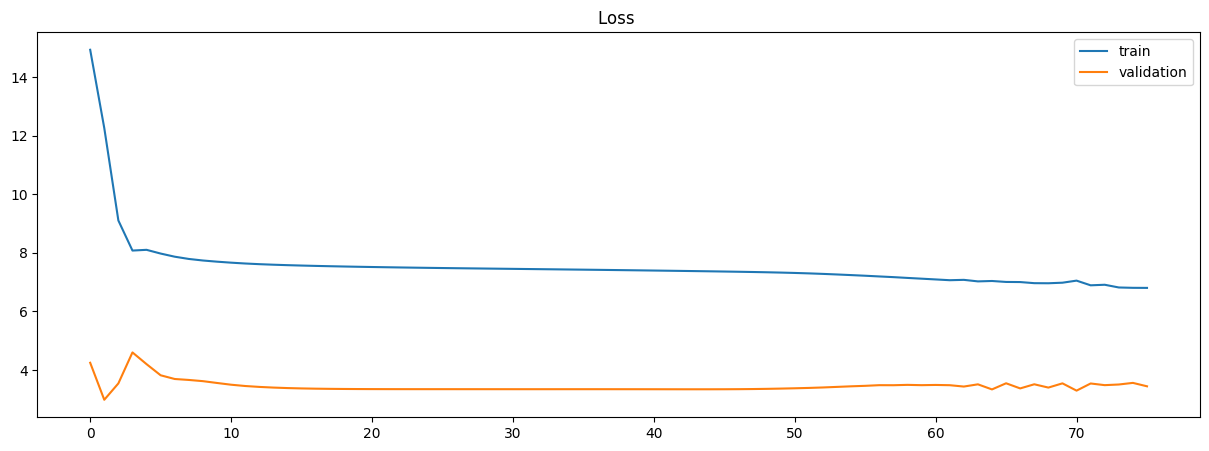

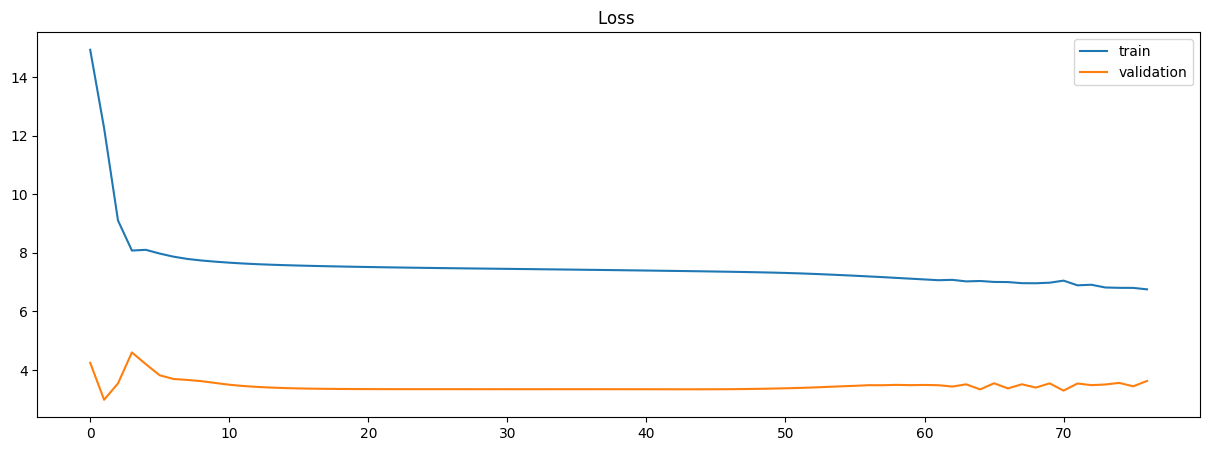

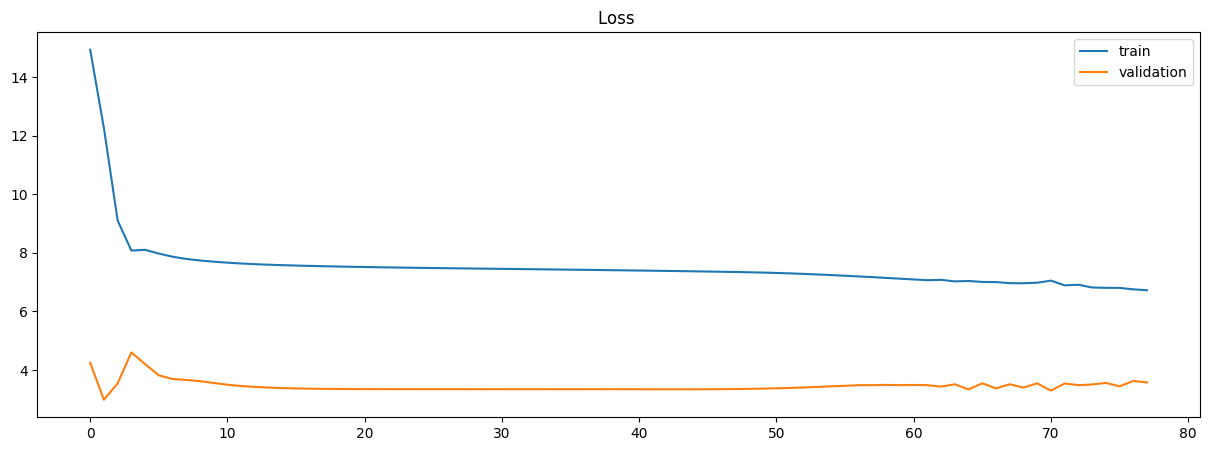

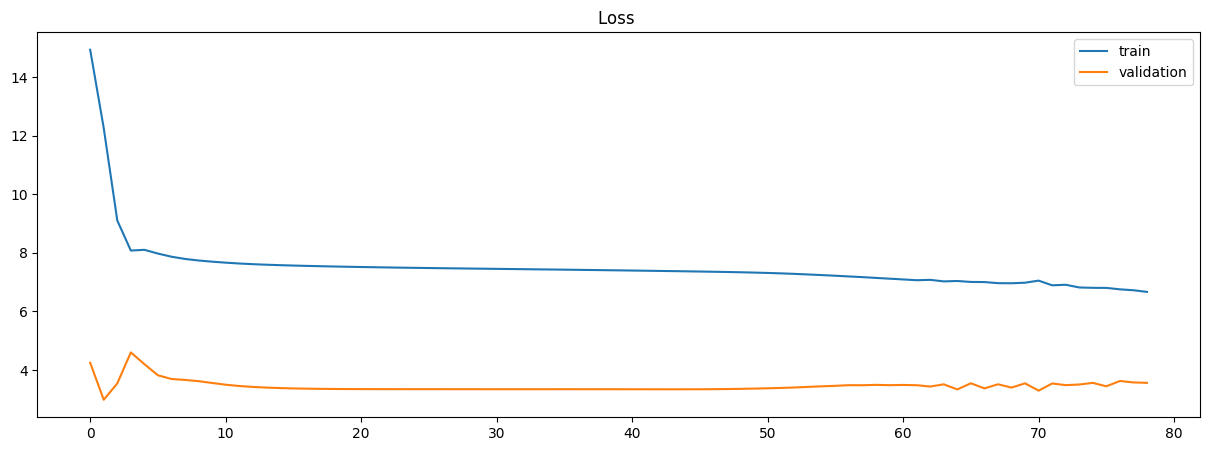

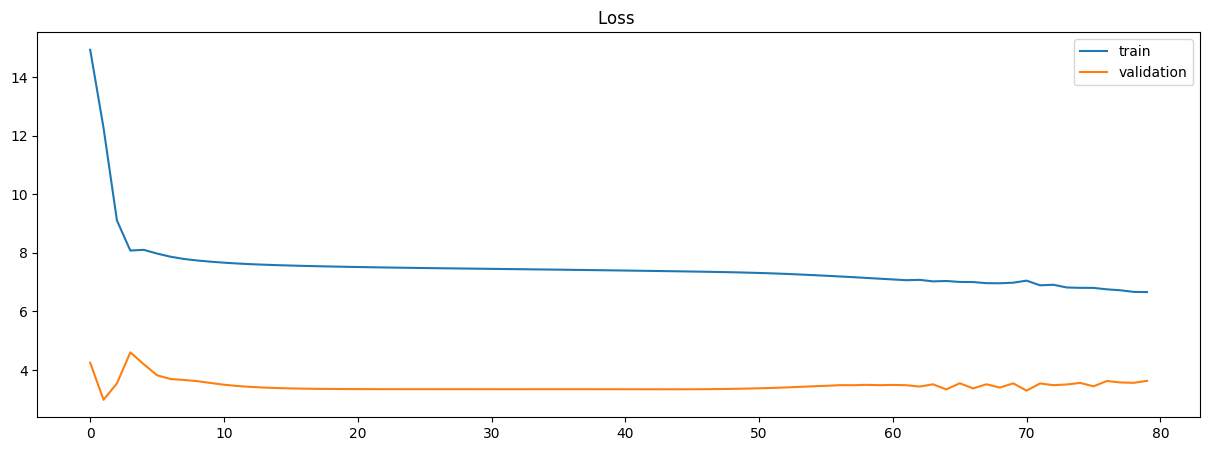

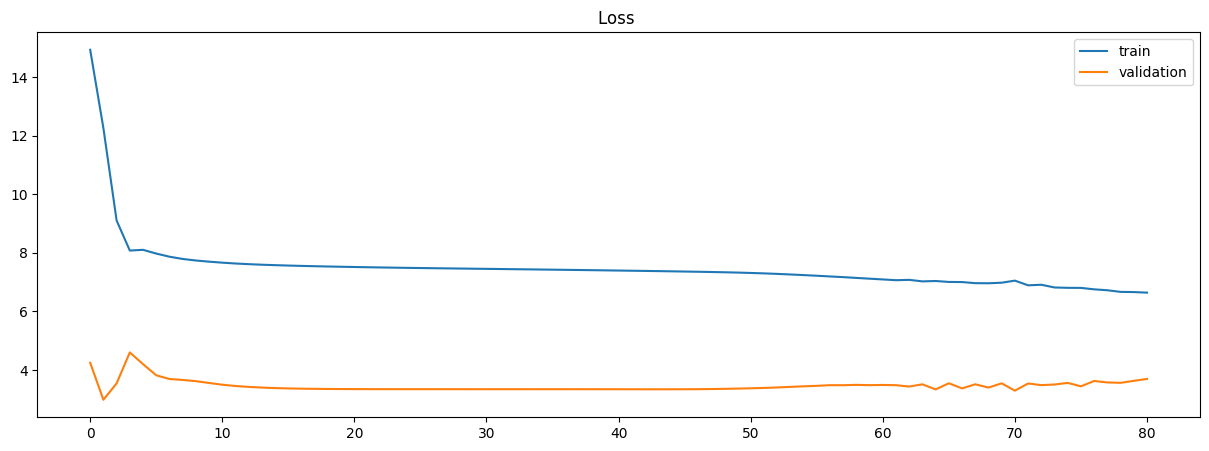

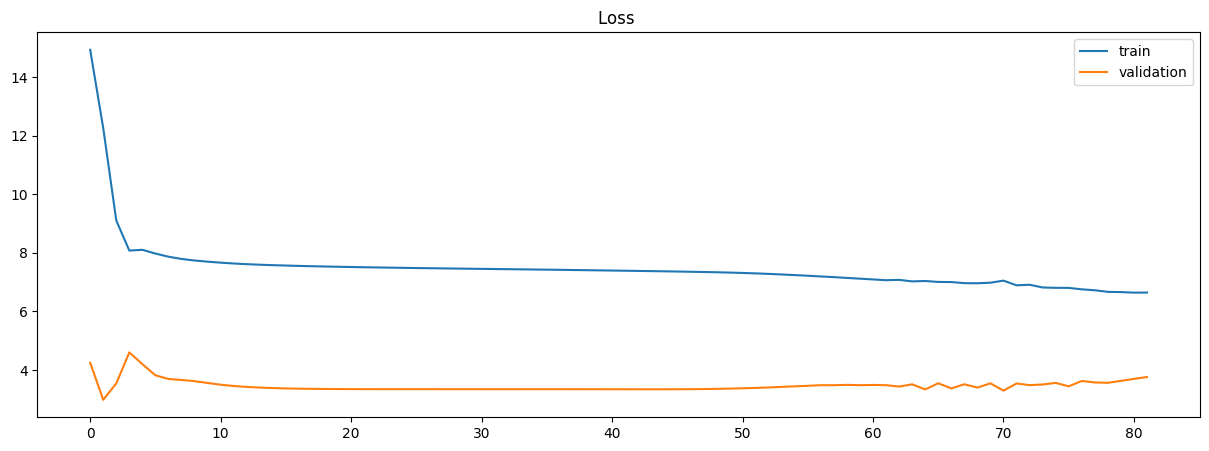

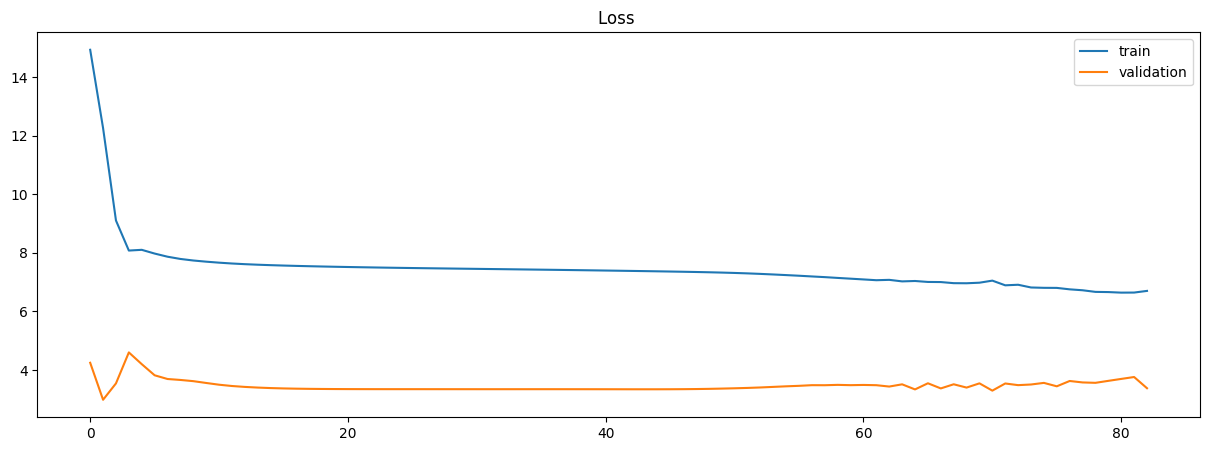

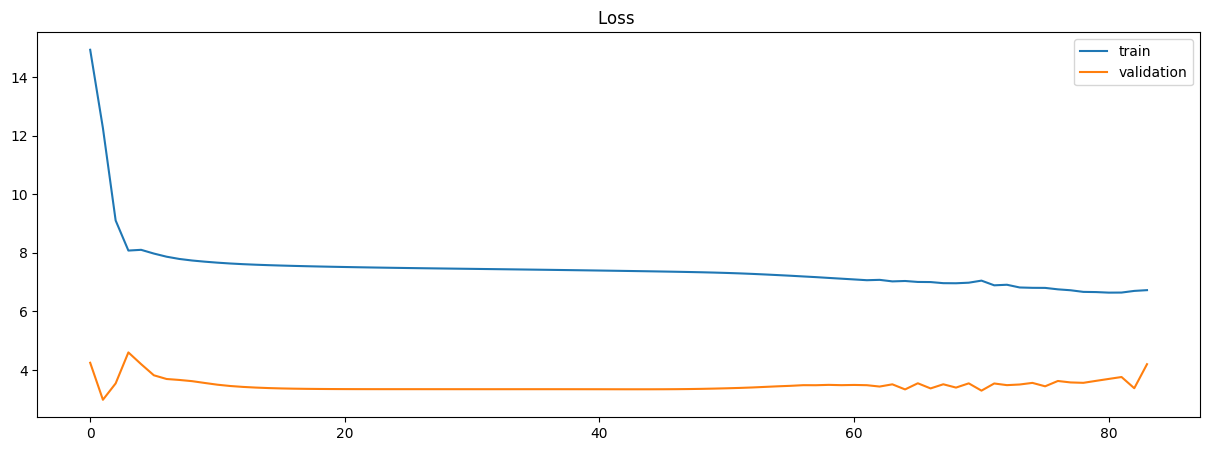

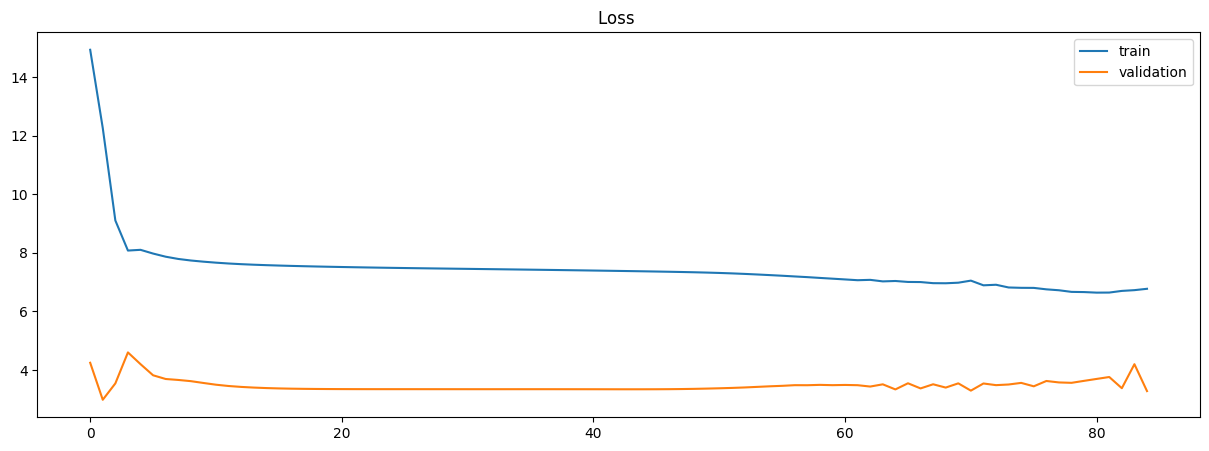

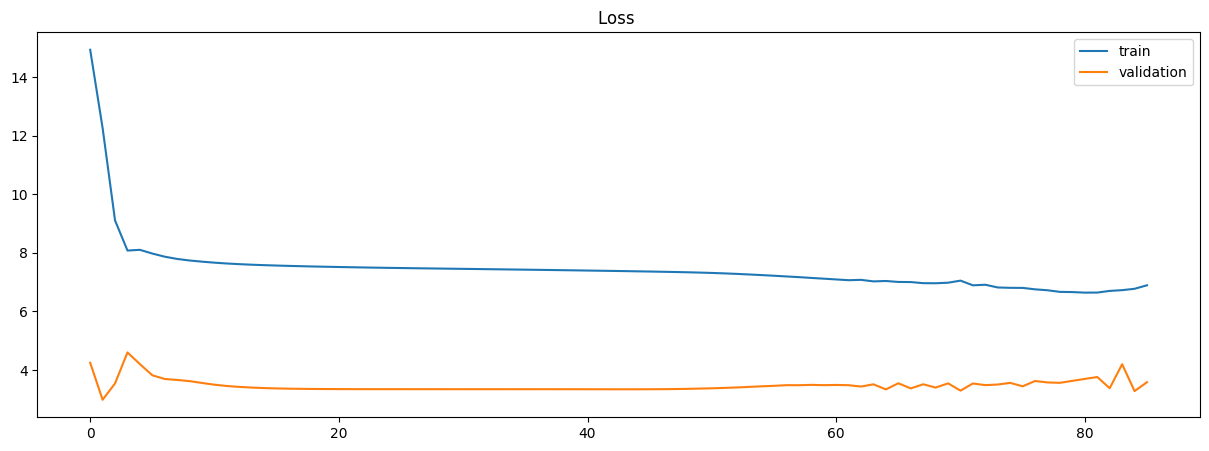

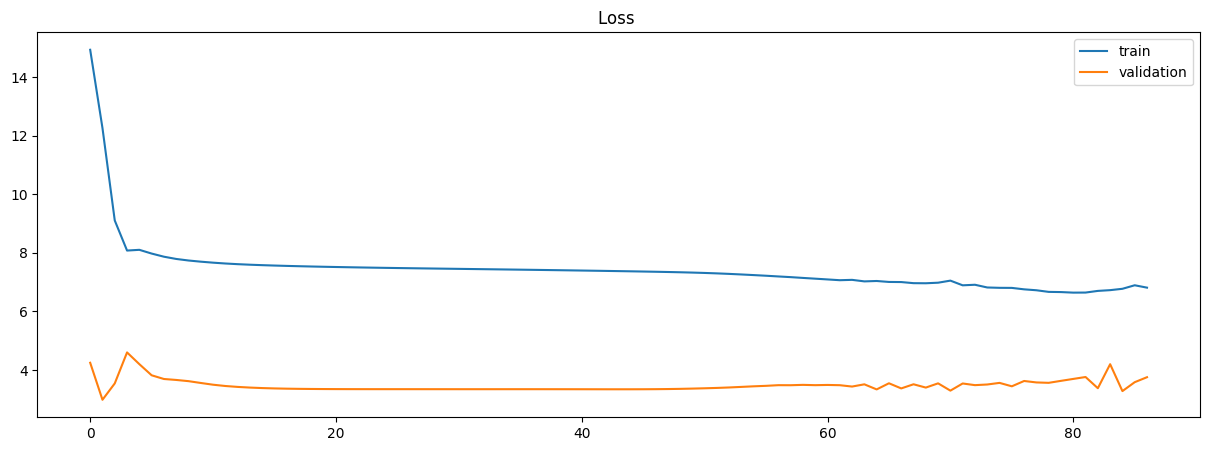

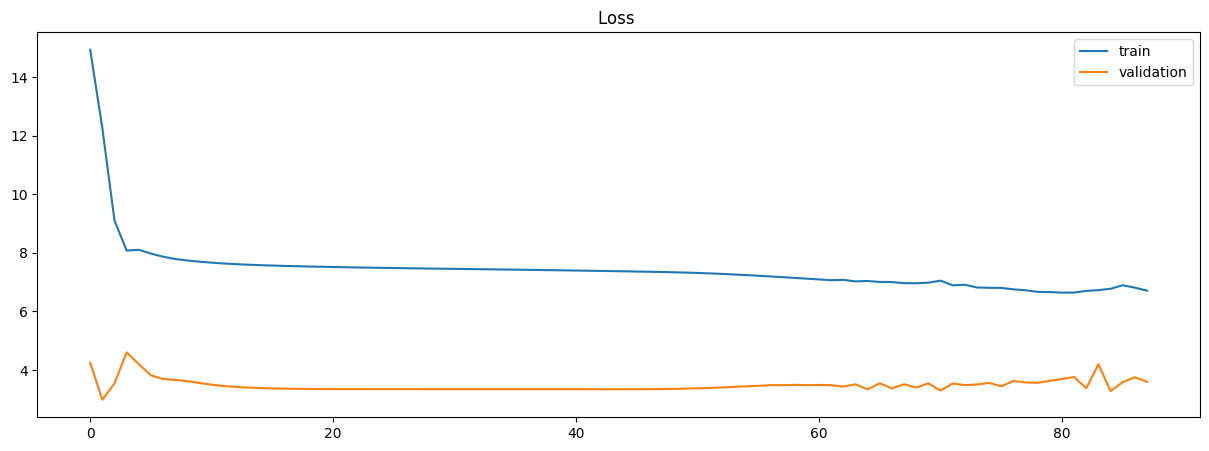

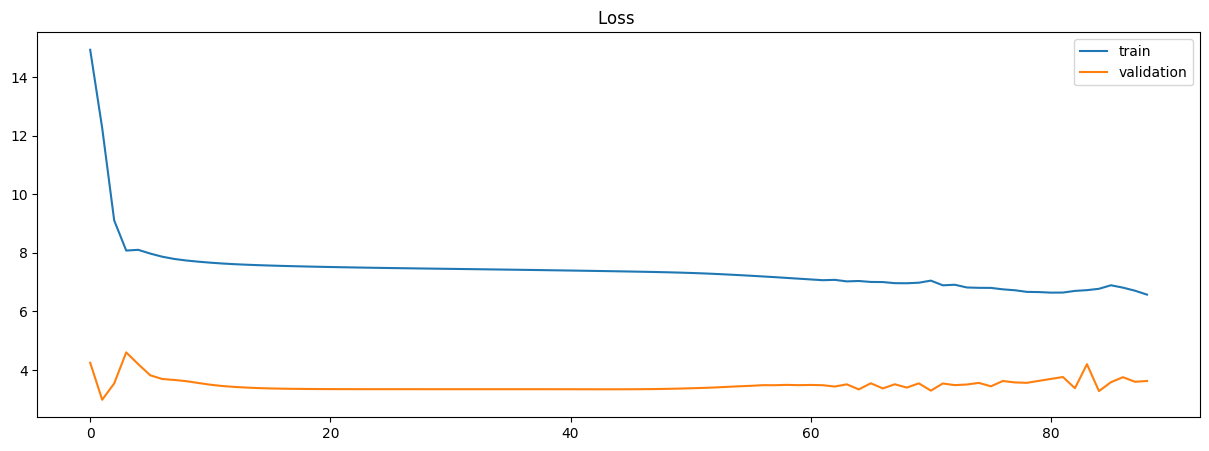

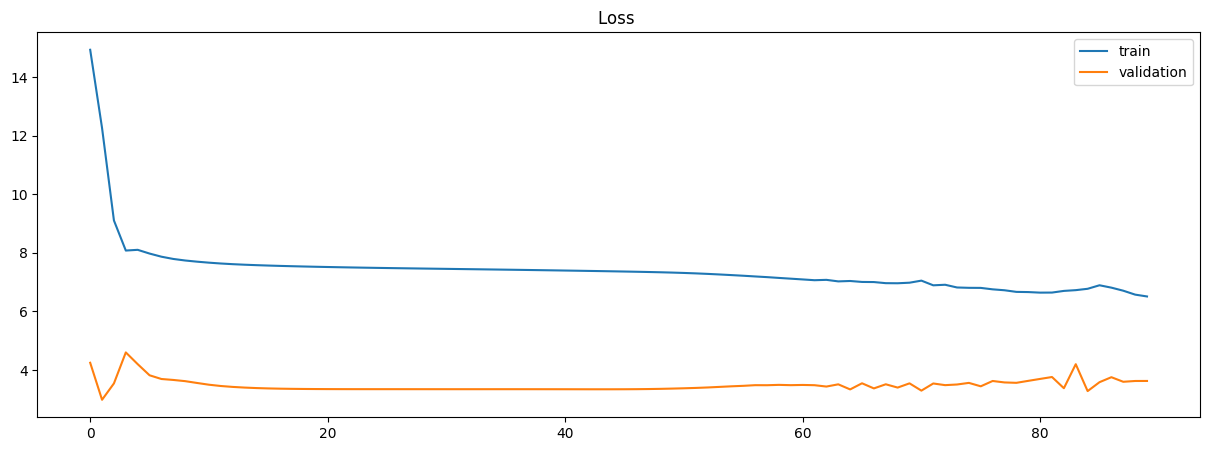

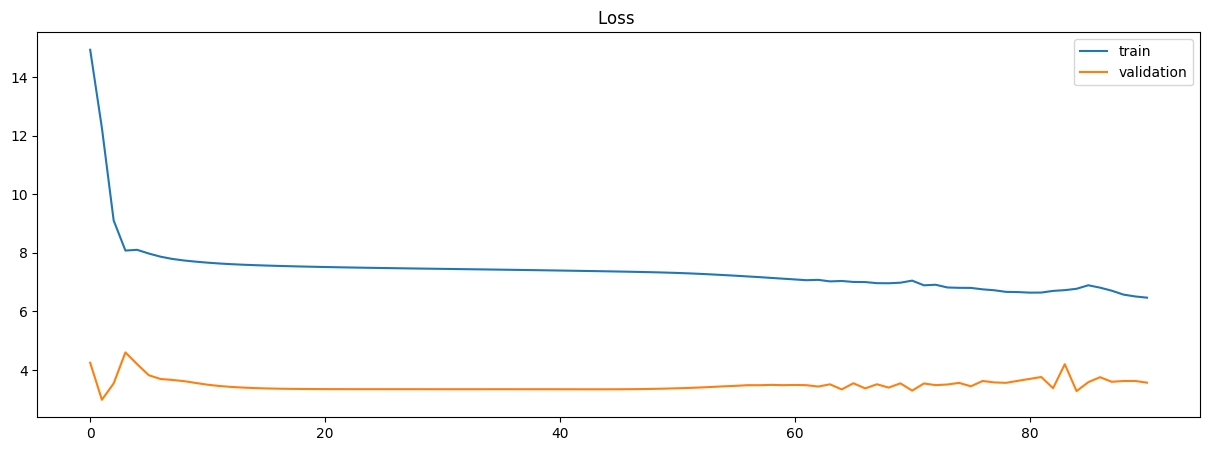

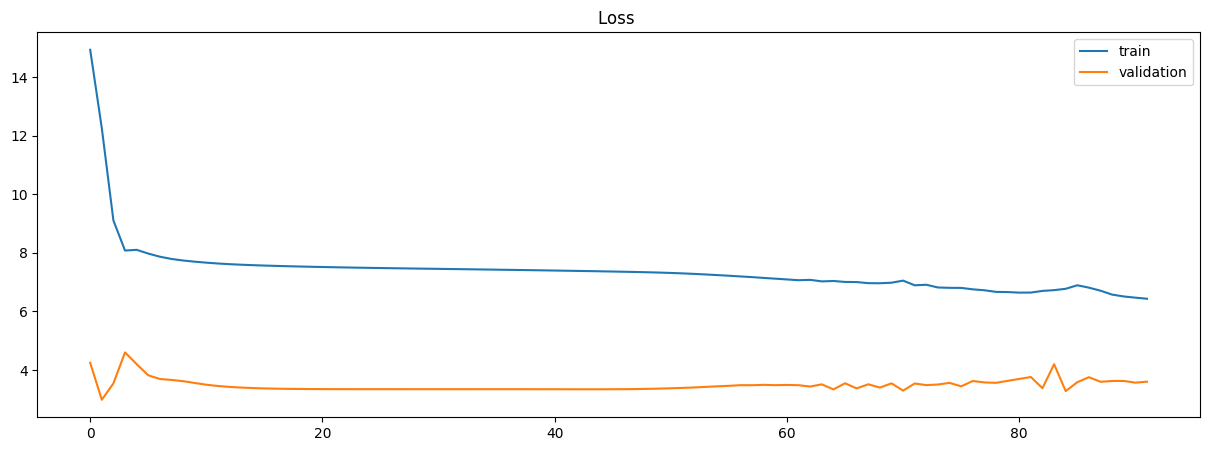

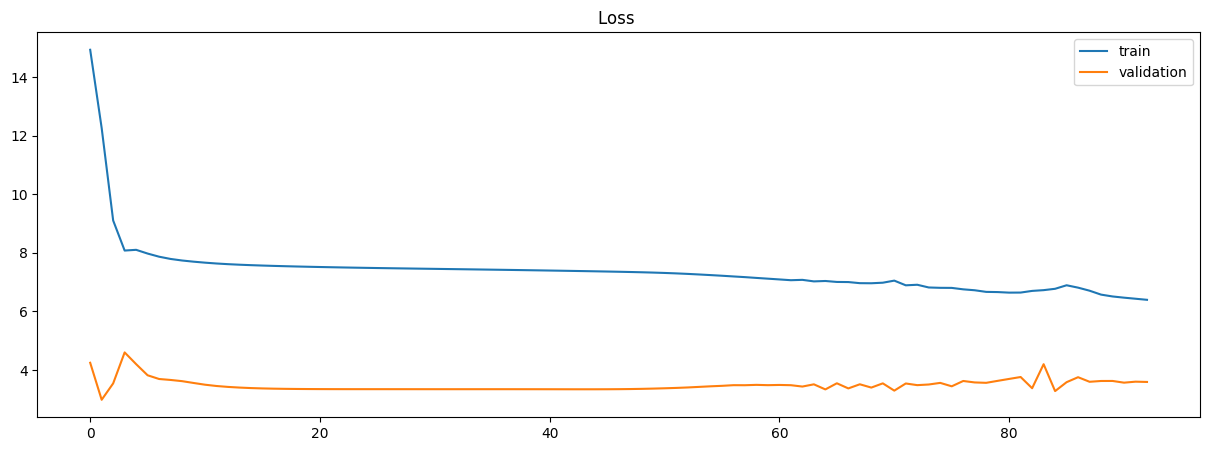

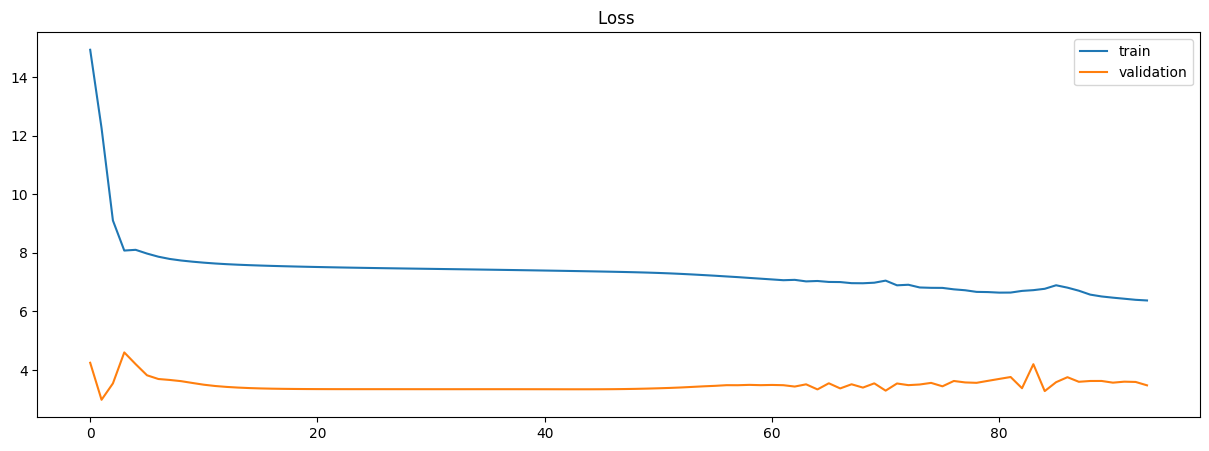

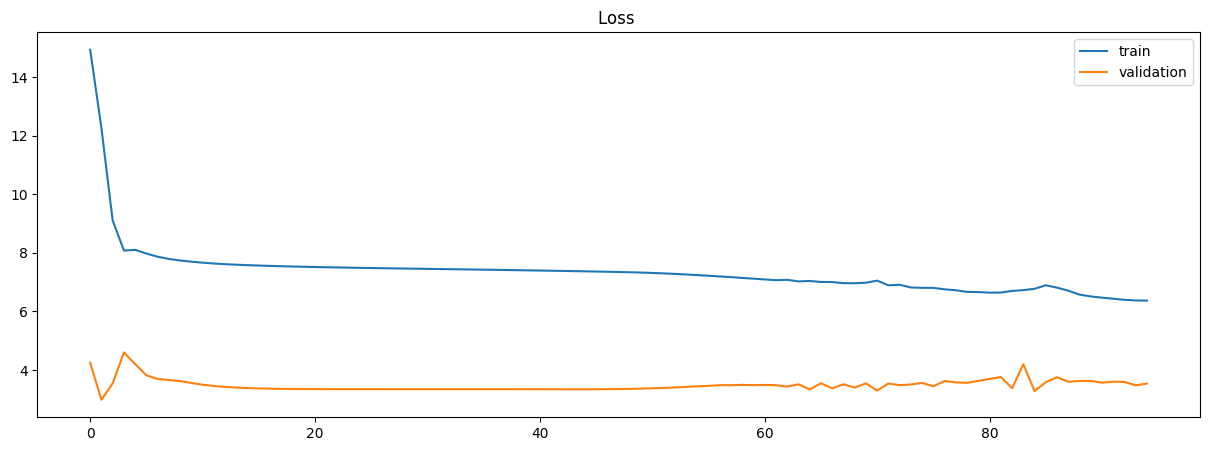

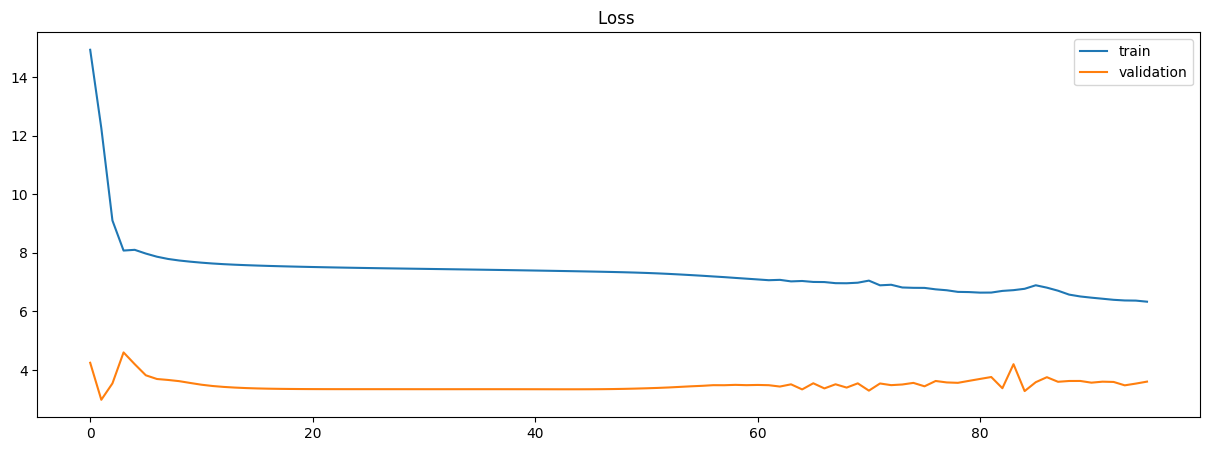

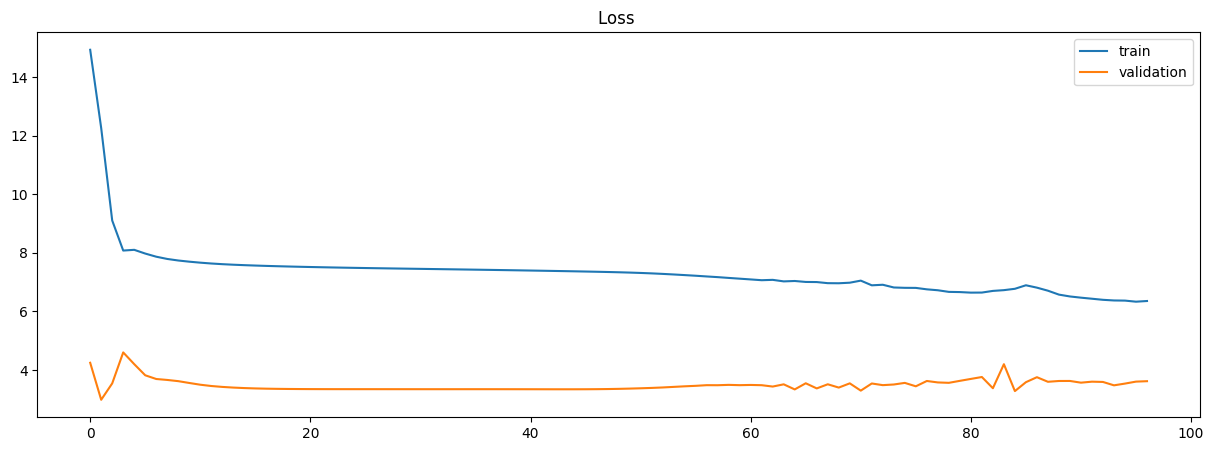

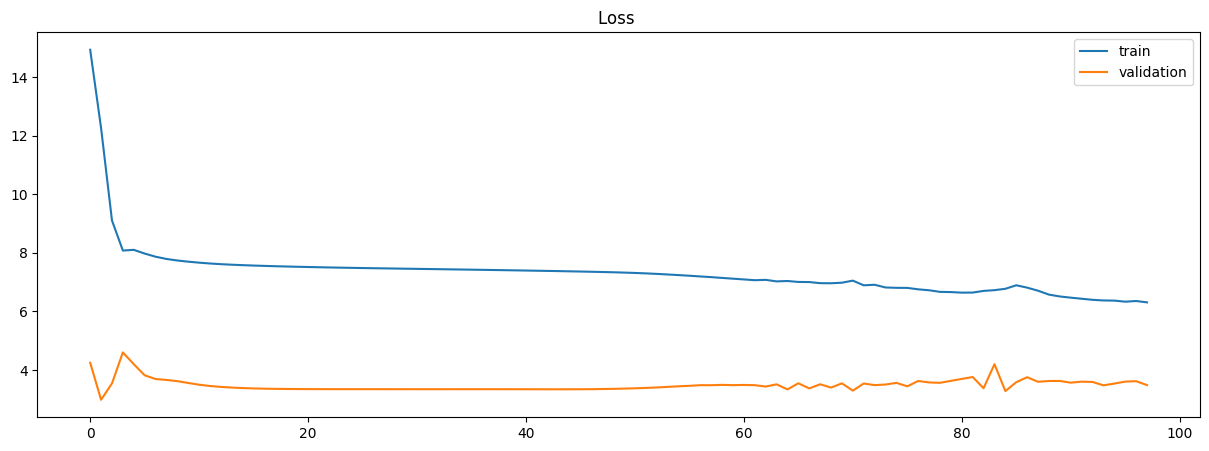

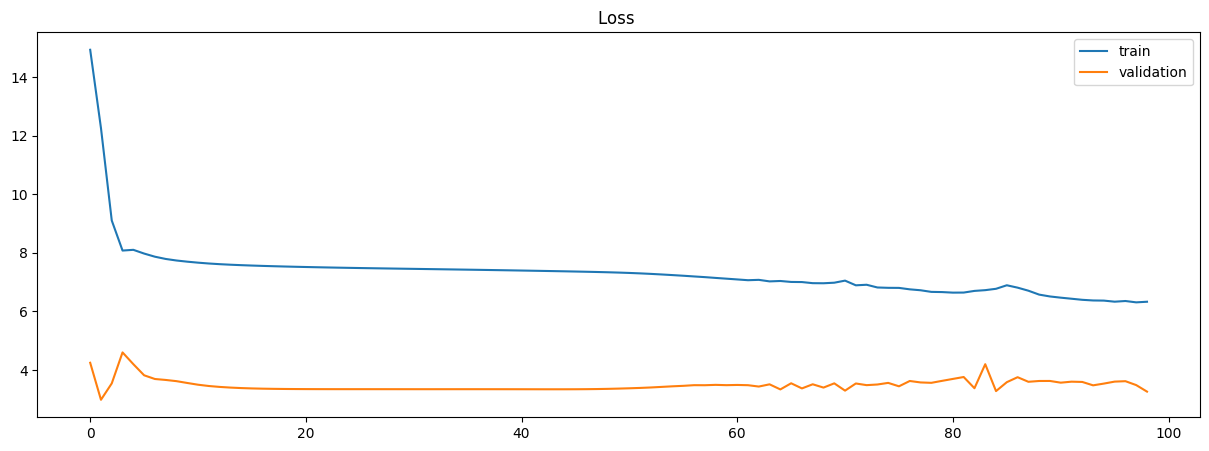

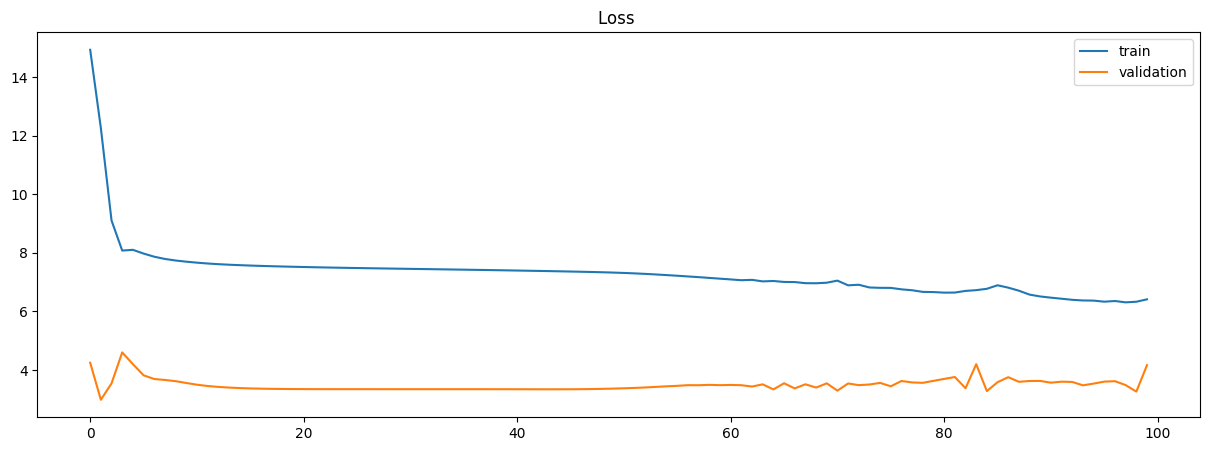

In [162]:
NUM_INPUT_SIZE = 3
LSTM_H = 128
LSTM_NUM_LAYERS = 1
FC_HIDDEN = 128
DROPOUT = 0.1
LR = 3e-4
EPOCHS = 100

model = CatEmbLSTM(NUM_INPUT_SIZE, LSTM_H, LSTM_NUM_LAYERS, fc_hidden=FC_HIDDEN, dropout=DROPOUT)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), LR)

train_loader = get_subsample(train_data)
val_loader = get_subsample(test_data)

output_dict = train(model, train_loader, val_loader, optimizer, criterion, EPOCHS, True, every_epoch=1)


In [163]:
y_pred, y_gt = test_loop(model, val_loader())

predicted = torch.cat(y_pred).view(-1).detach().cpu().numpy()

In [164]:

len(y_pred),y_pred[0].shape

(1, torch.Size([2, 30]))

In [165]:
predicted=np.concatenate([[None]*(test_data.shape[0]-predicted.shape[0]), predicted])

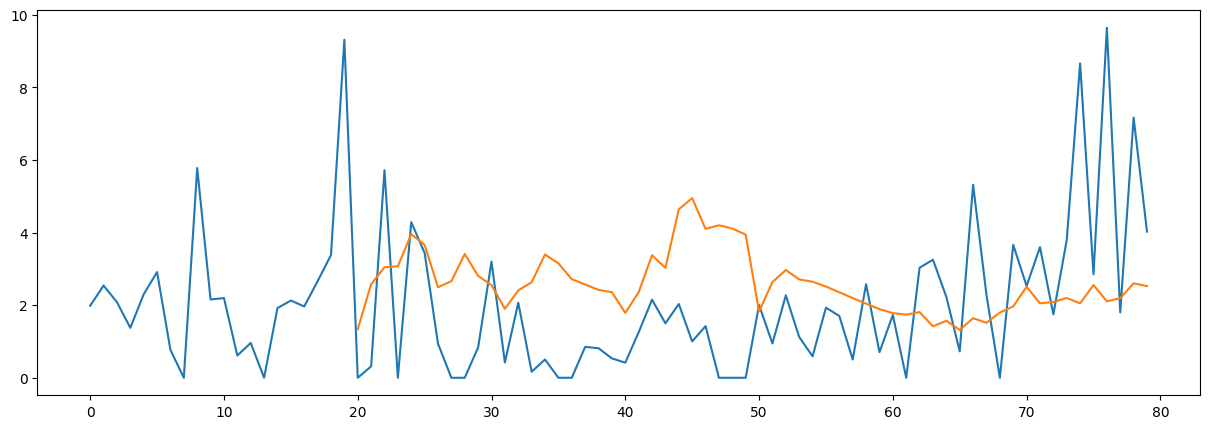

In [166]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

axes.plot(test_data[target].values)
axes.plot(predicted)

In [128]:
shift=40
(np.abs((predicted[shift:]-test_data.iloc[shift:][target].values))**2).mean()

4.335970066198781

In [59]:
y_gt

[tensor([[1.7280, 0.0000, 3.0320, 3.2520, 2.2280]])]